## Importations

In [1]:
## plots
import matplotlib.pyplot as plt
from matplotlib import rc

##
import numpy as np

import sys
sys.path.append('../')

## ML :
from scripts.machine_learning_utils import *
from scripts.models import *
from scripts.descriptors import *


import pandas as pd



rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)

Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get data

In [2]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

df_OCO = df_total[df_total.group == 'OCO']
df_ONO = df_total[df_total.group == 'ONO']
df_NNN = df_total[df_total.group == 'NNN']
df_triarylboranes = df_total[df_total.group == "triarylboranes"]

## Hierarchical clustering

In [3]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
import seaborn as sns

In [4]:
X = create_descriptors(df_total.index, "quantum")
names = get_names('quantum')
df_X = pd.DataFrame(X)
df_X.columns = names

In [5]:
reduced_features = list(names[:])
reduced_features.remove("multiplicity")
reduced_features.remove("charge")
reduced_features.remove("converged")

df_X = df_X.loc[:,reduced_features] 
#remove features not seen during fit

In [6]:
corr_sp = df_X.corr('spearman') #correlation matrix

distance_sp = 1 - abs(corr_sp) #distance matrix

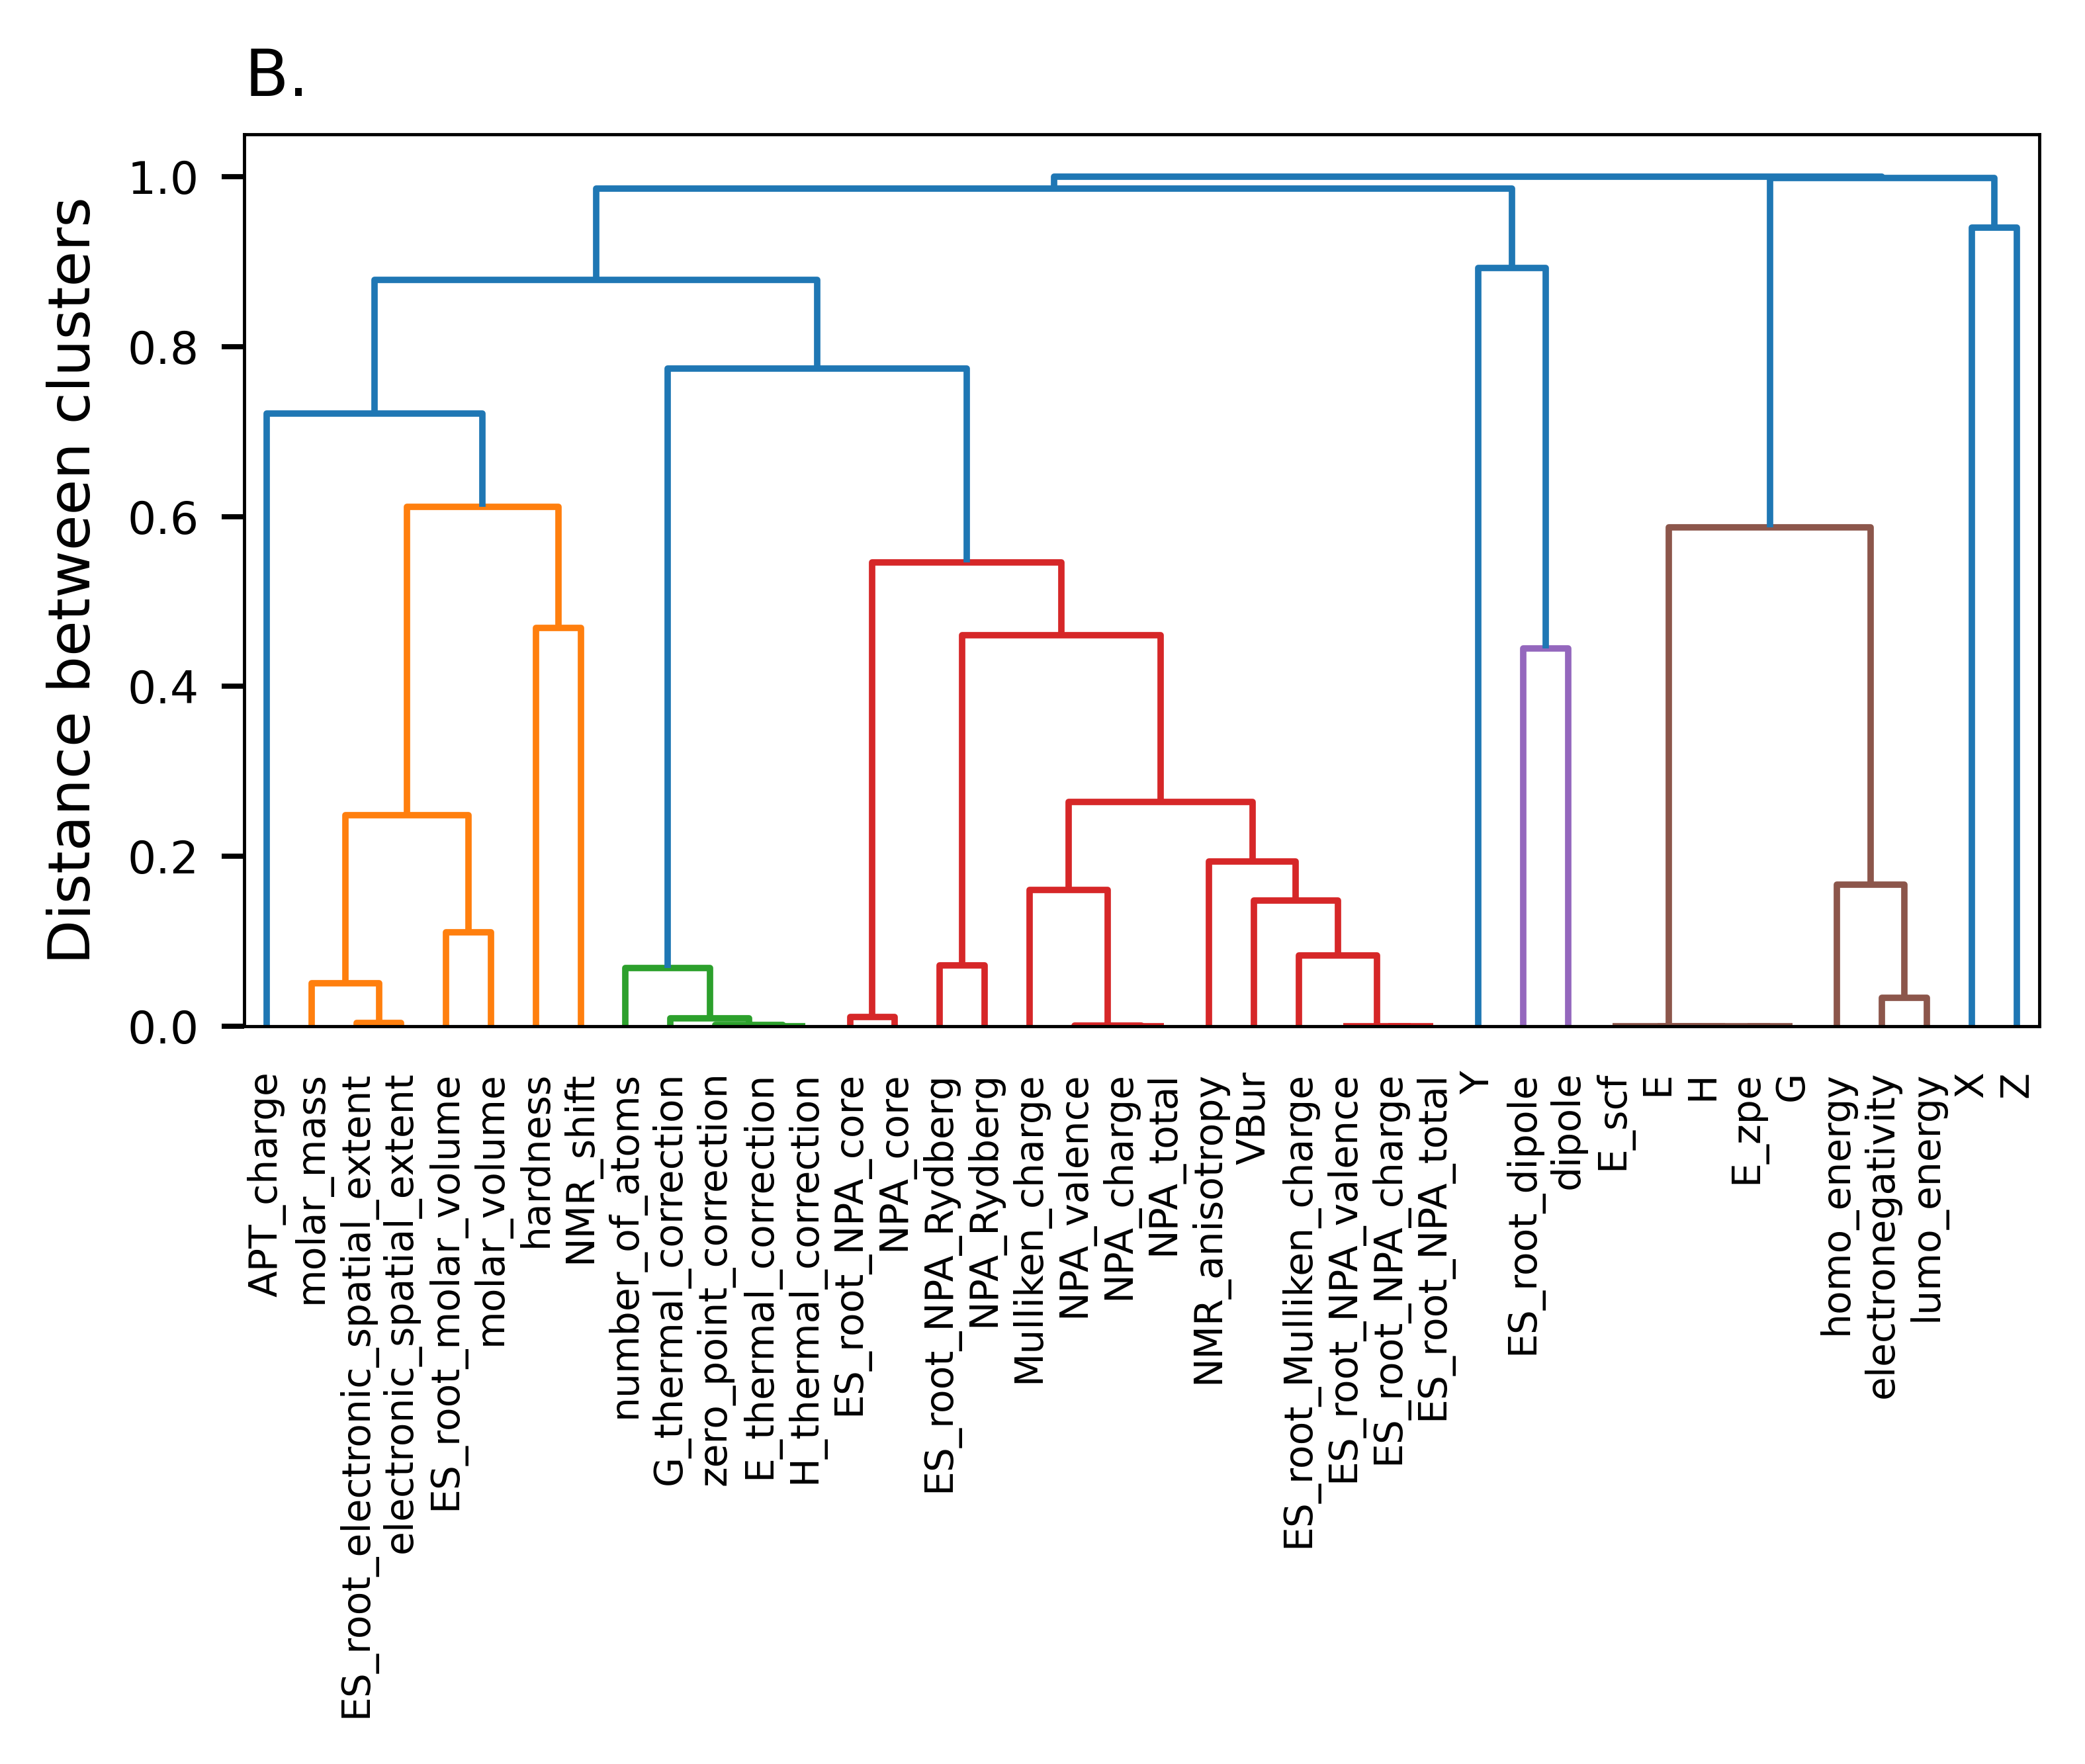

In [9]:
fig, ax = plt.subplots(figsize=(5,2.5))
Z = hierarchy.linkage(squareform(distance_sp), 'complete')

plt.ylabel("Distance between clusters", size = 9)
hierarchy.dendrogram(Z, labels=df_X.columns, orientation='top', 
           leaf_rotation=90);
plt.xticks(fontsize = 6)

ax.set_title('B.', loc='left', fontsize =10)

fig.savefig(f'../results/interpretability/quantum_descriptors/hierarchy_clustering_complete_linkage_quantum_descr_df_all.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

In [20]:
from collections import defaultdict


cluster_ids = hierarchy.fcluster(Z, 0.45, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(df_X.columns[idx])
#selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
#selected_features_names = X.columns[selected_features] # renvoie le nom de la feature d'indice le plus bas du cluster. 
#Donc pas de choix particulier.

In [25]:
uncorrelated_features = ['H', 'dipole', 'molar_volume', 'H_thermal_correction', 'electronegativity', 'hardness', "APT_charge", "NPA_charge", "NPA_Rydberg", 'NPA_core', 'NMR_shift', 'X']

Reduce descriptors to uncorrelated features

In [208]:
names = get_names('quantum')
df_X = pd.DataFrame(X)
df_X.columns = names
df_X_uncor = df_X.loc[:,uncorrelated_features]
X_uncor = np.array(df_X_uncor)

In [167]:
scores = evaluate_model(model, X_uncor,Y, n_rep=5)
np.mean(scores)

-9.969104482620631

## Interprete coefficients of ridge model

 ### choose the model

In [162]:
model = Ridge(alpha=0.0001, random_state=1, tol=1e-05) 
# obtained from grid searching on the total database (4 structures)
# with the quantum descriptors

#try also other kinds of linear models 
#model = LinearRegression()
#model = Lasso(alpha=0.1, max_iter=1000, precompute=False, 
 #             selection = 'random', random_state=1, tol=0.0001)
#model = Ridge(alpha=5, max_iter=500, random_state=1, tol=0.0001, solver = 'sparse_cg')



In [163]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()),('selector', VarianceThreshold()), ('m',model)])

Choose the descriptors

In [207]:
descriptors = "quantum"
X = create_descriptors(df_ONO.index, descriptors, data = data_Q_tot)
Y = df_ONO.FIA

In [164]:
scores = evaluate_model(model, X,Y, n_rep=5)
np.mean(scores)

-7.235952906096359

#### Grid search

In [43]:
model = Ridge()

In [45]:
model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [49]:
grid_params = {'m__alpha': [ 0.001, 0.01, 0.1,1.0, 5],
 'm__tol': [1e-6, 0.00001,0.0001, 0.001, 0.01],
# 'm__precompute' : [True, False],
 # 'm__selection' : ['cyclic', 'random']}              
  'm__solver' : ["auto", "svd", 'sparse_cg', 'saga']}

In [50]:
from sklearn.model_selection import GridSearchCV
pipe = Pipeline(steps=[ ('scaler', StandardScaler()),('selector', VarianceThreshold()), ('m',model)])
grid_cv = GridSearchCV(pipe, grid_params, cv = 4, verbose=4, n_jobs = -1, scoring = 'neg_mean_absolute_error')

grid_cv.fit(X_uncor,Y)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', VarianceThreshold()),
                                       ('m', Ridge())]),
             n_jobs=-1,
             param_grid={'m__alpha': [0.001, 0.01, 0.1, 1.0, 5],
                         'm__solver': ['auto', 'svd', 'sparse_cg', 'saga'],
                         'm__tol': [1e-06, 1e-05, 0.0001, 0.001, 0.01]},
             scoring='neg_mean_absolute_error', verbose=4)

In [ ]:
df = pd.DataFrame(grid_cv.cv_results_)
df.sort_values('mean_test_score', ascending = False)

In [52]:
grid_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('m', Ridge(alpha=5, solver='saga', tol=0.01))])

In [53]:
model_selec = Ridge(alpha=5, solver='saga', tol=0.01)
scores = evaluate_model(model_selec, X_uncor,Y, n_rep=5)
np.mean(scores)

-22.056569441667424

#### Interprete coeffs

Fit the model

In [209]:
model_linear = LinearRegression()
pipeline = Pipeline(steps=[('scaler', StandardScaler()),('selector', VarianceThreshold()), ('m',model_linear)])

In [210]:
pipeline.fit(X_uncor,Y)

Pipeline(steps=[('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('m', LinearRegression())])

In [211]:
## to get the features seen during fit of the model

#names = get_names(descriptors)
fitted_features = list(pipeline[:-1].get_feature_names_out(uncorrelated_features))
print(fitted_features)
print(len(fitted_features))

['H', 'dipole', 'molar_volume', 'H_thermal_correction', 'electronegativity', 'hardness', 'APT_charge', 'NPA_charge', 'NPA_Rydberg', 'NPA_core', 'NMR_shift', 'X']
12


In [212]:
coefs = pd.DataFrame(
    model_linear.coef_,
    columns=["Coefficients"],
    index=fitted_features,
)
coefs["Absolute coef"] = abs(coefs["Coefficients"])

more_important_coefs = coefs.sort_values("Absolute coef", ascending = True)[:15]

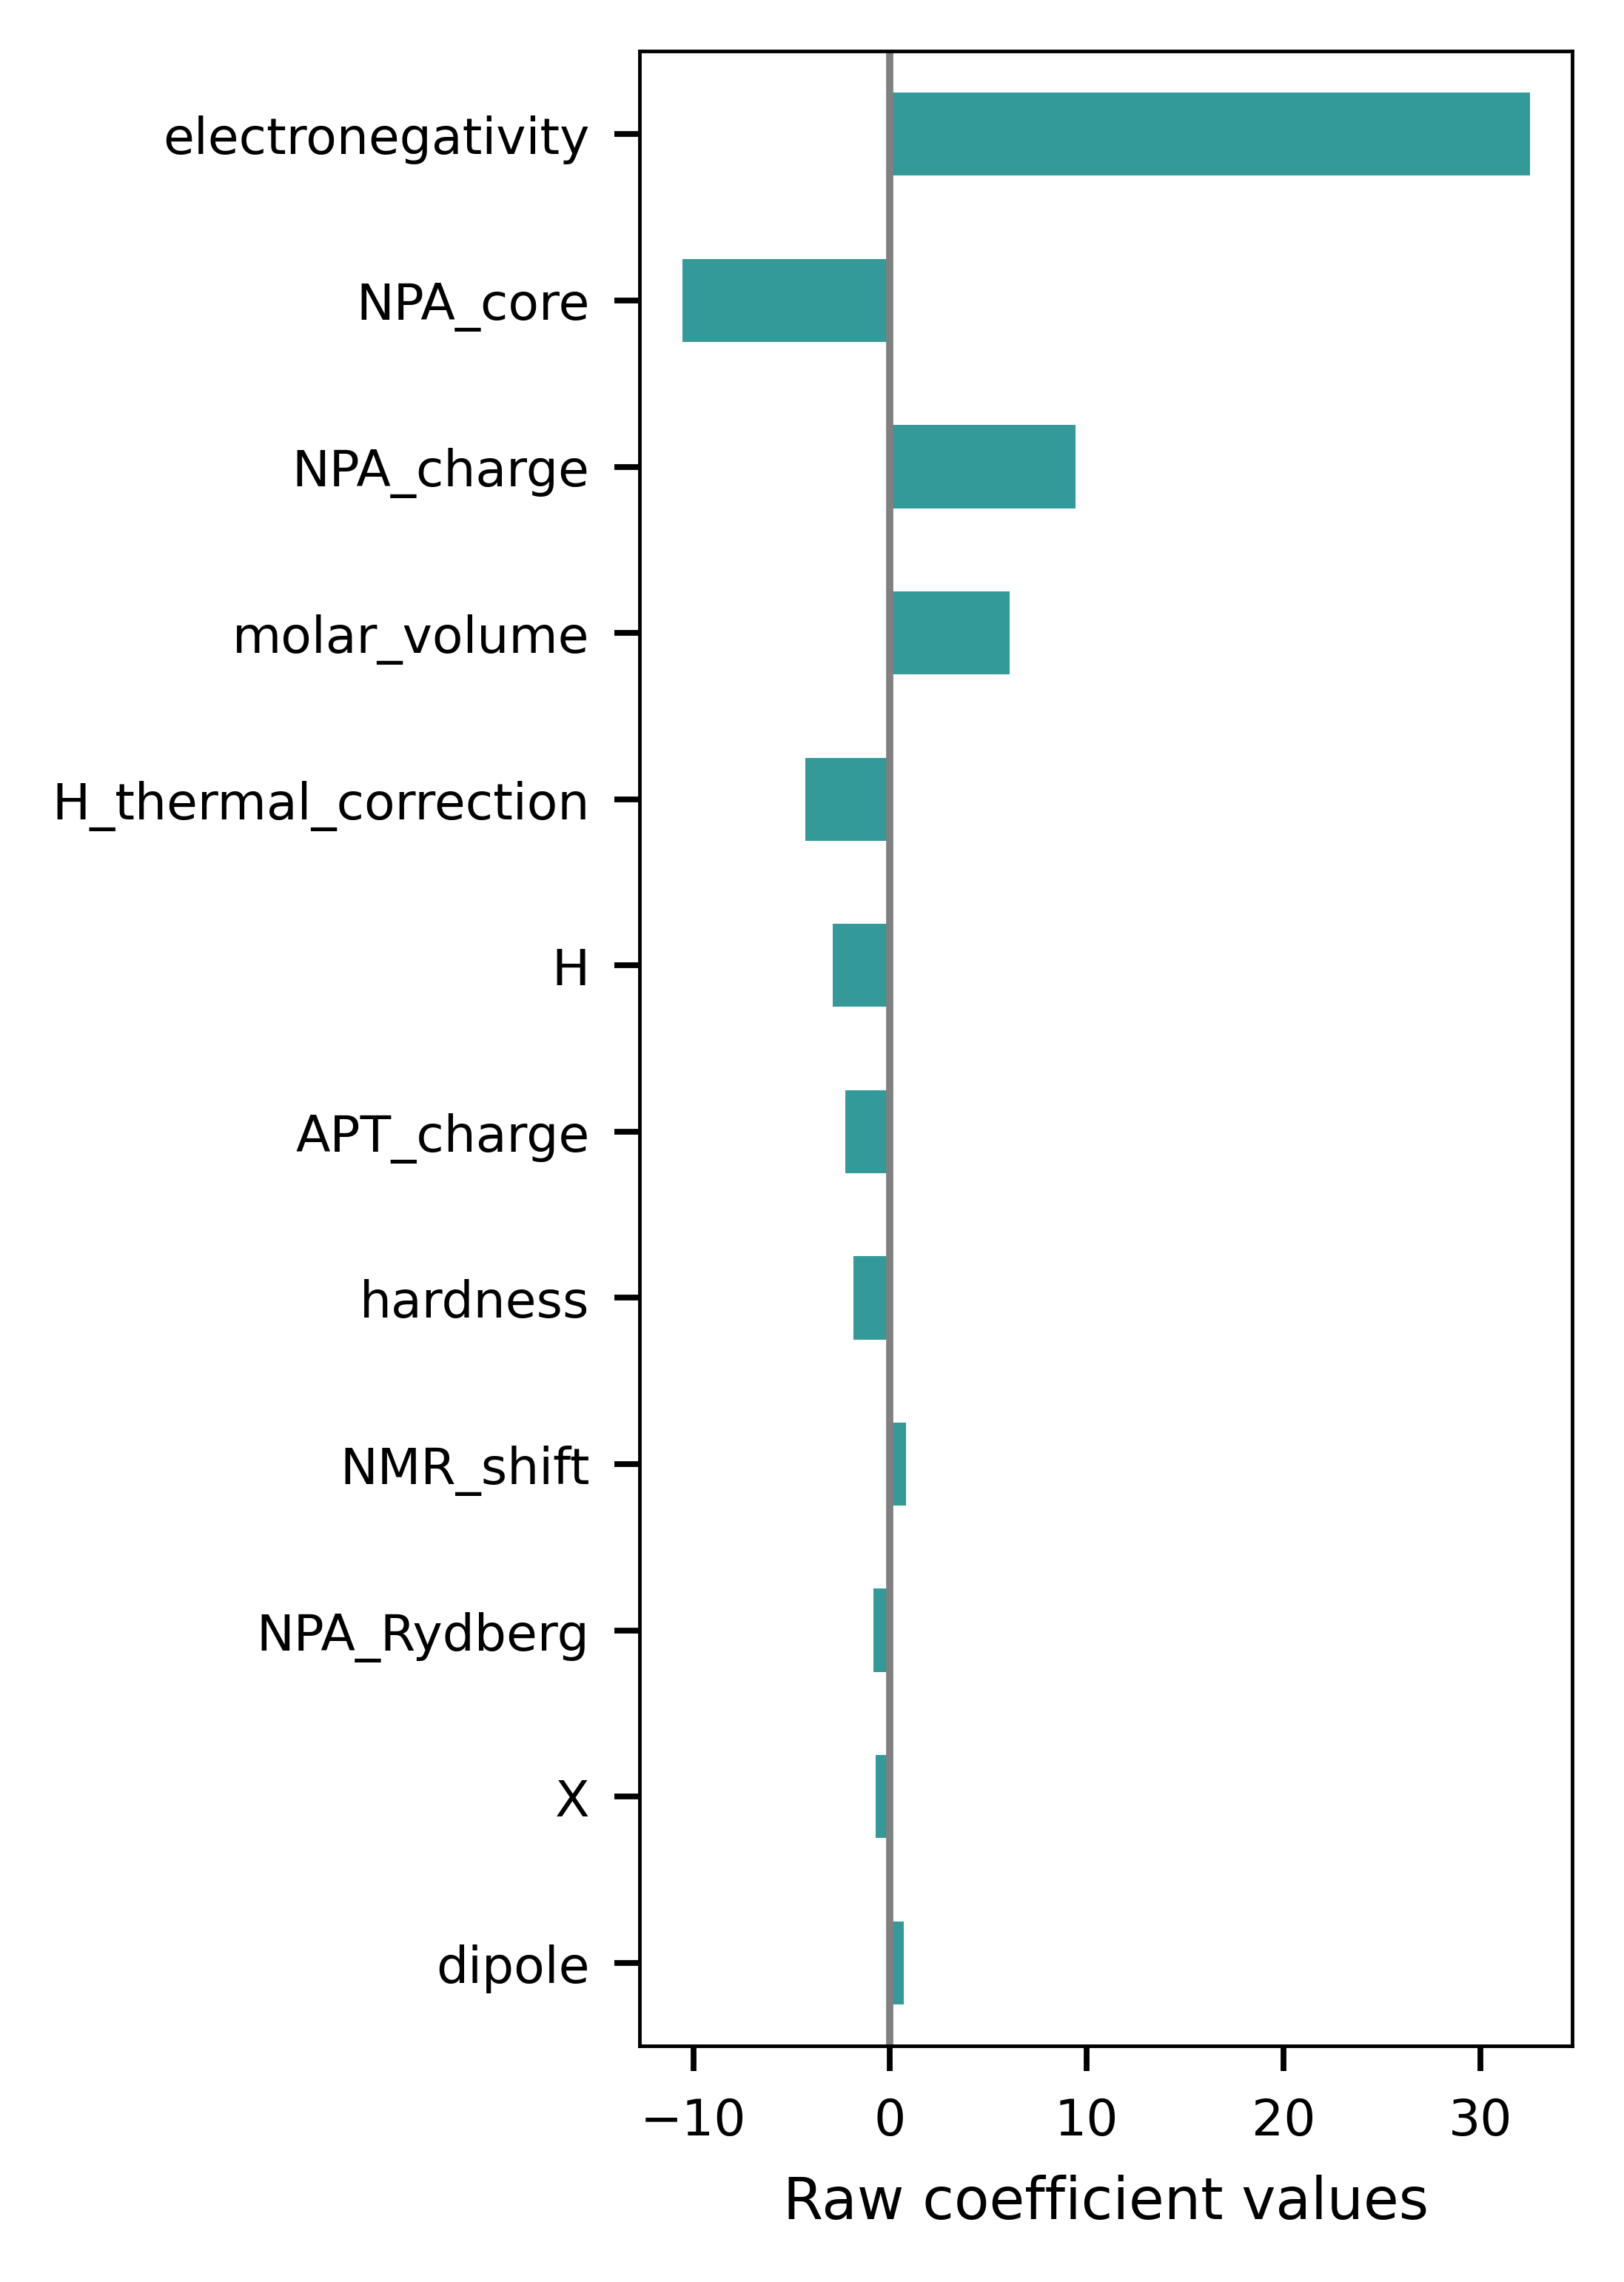

In [213]:
fig, ax = plt.subplots(figsize=(3, 5))

more_important_coefs["Coefficients"].plot.barh(color = 'teal', alpha = 0.8)
#ax.set_title( loc='left', fontsize =10)
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

fig.savefig(f'article/figures/coefficients_linear_model_ONO.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

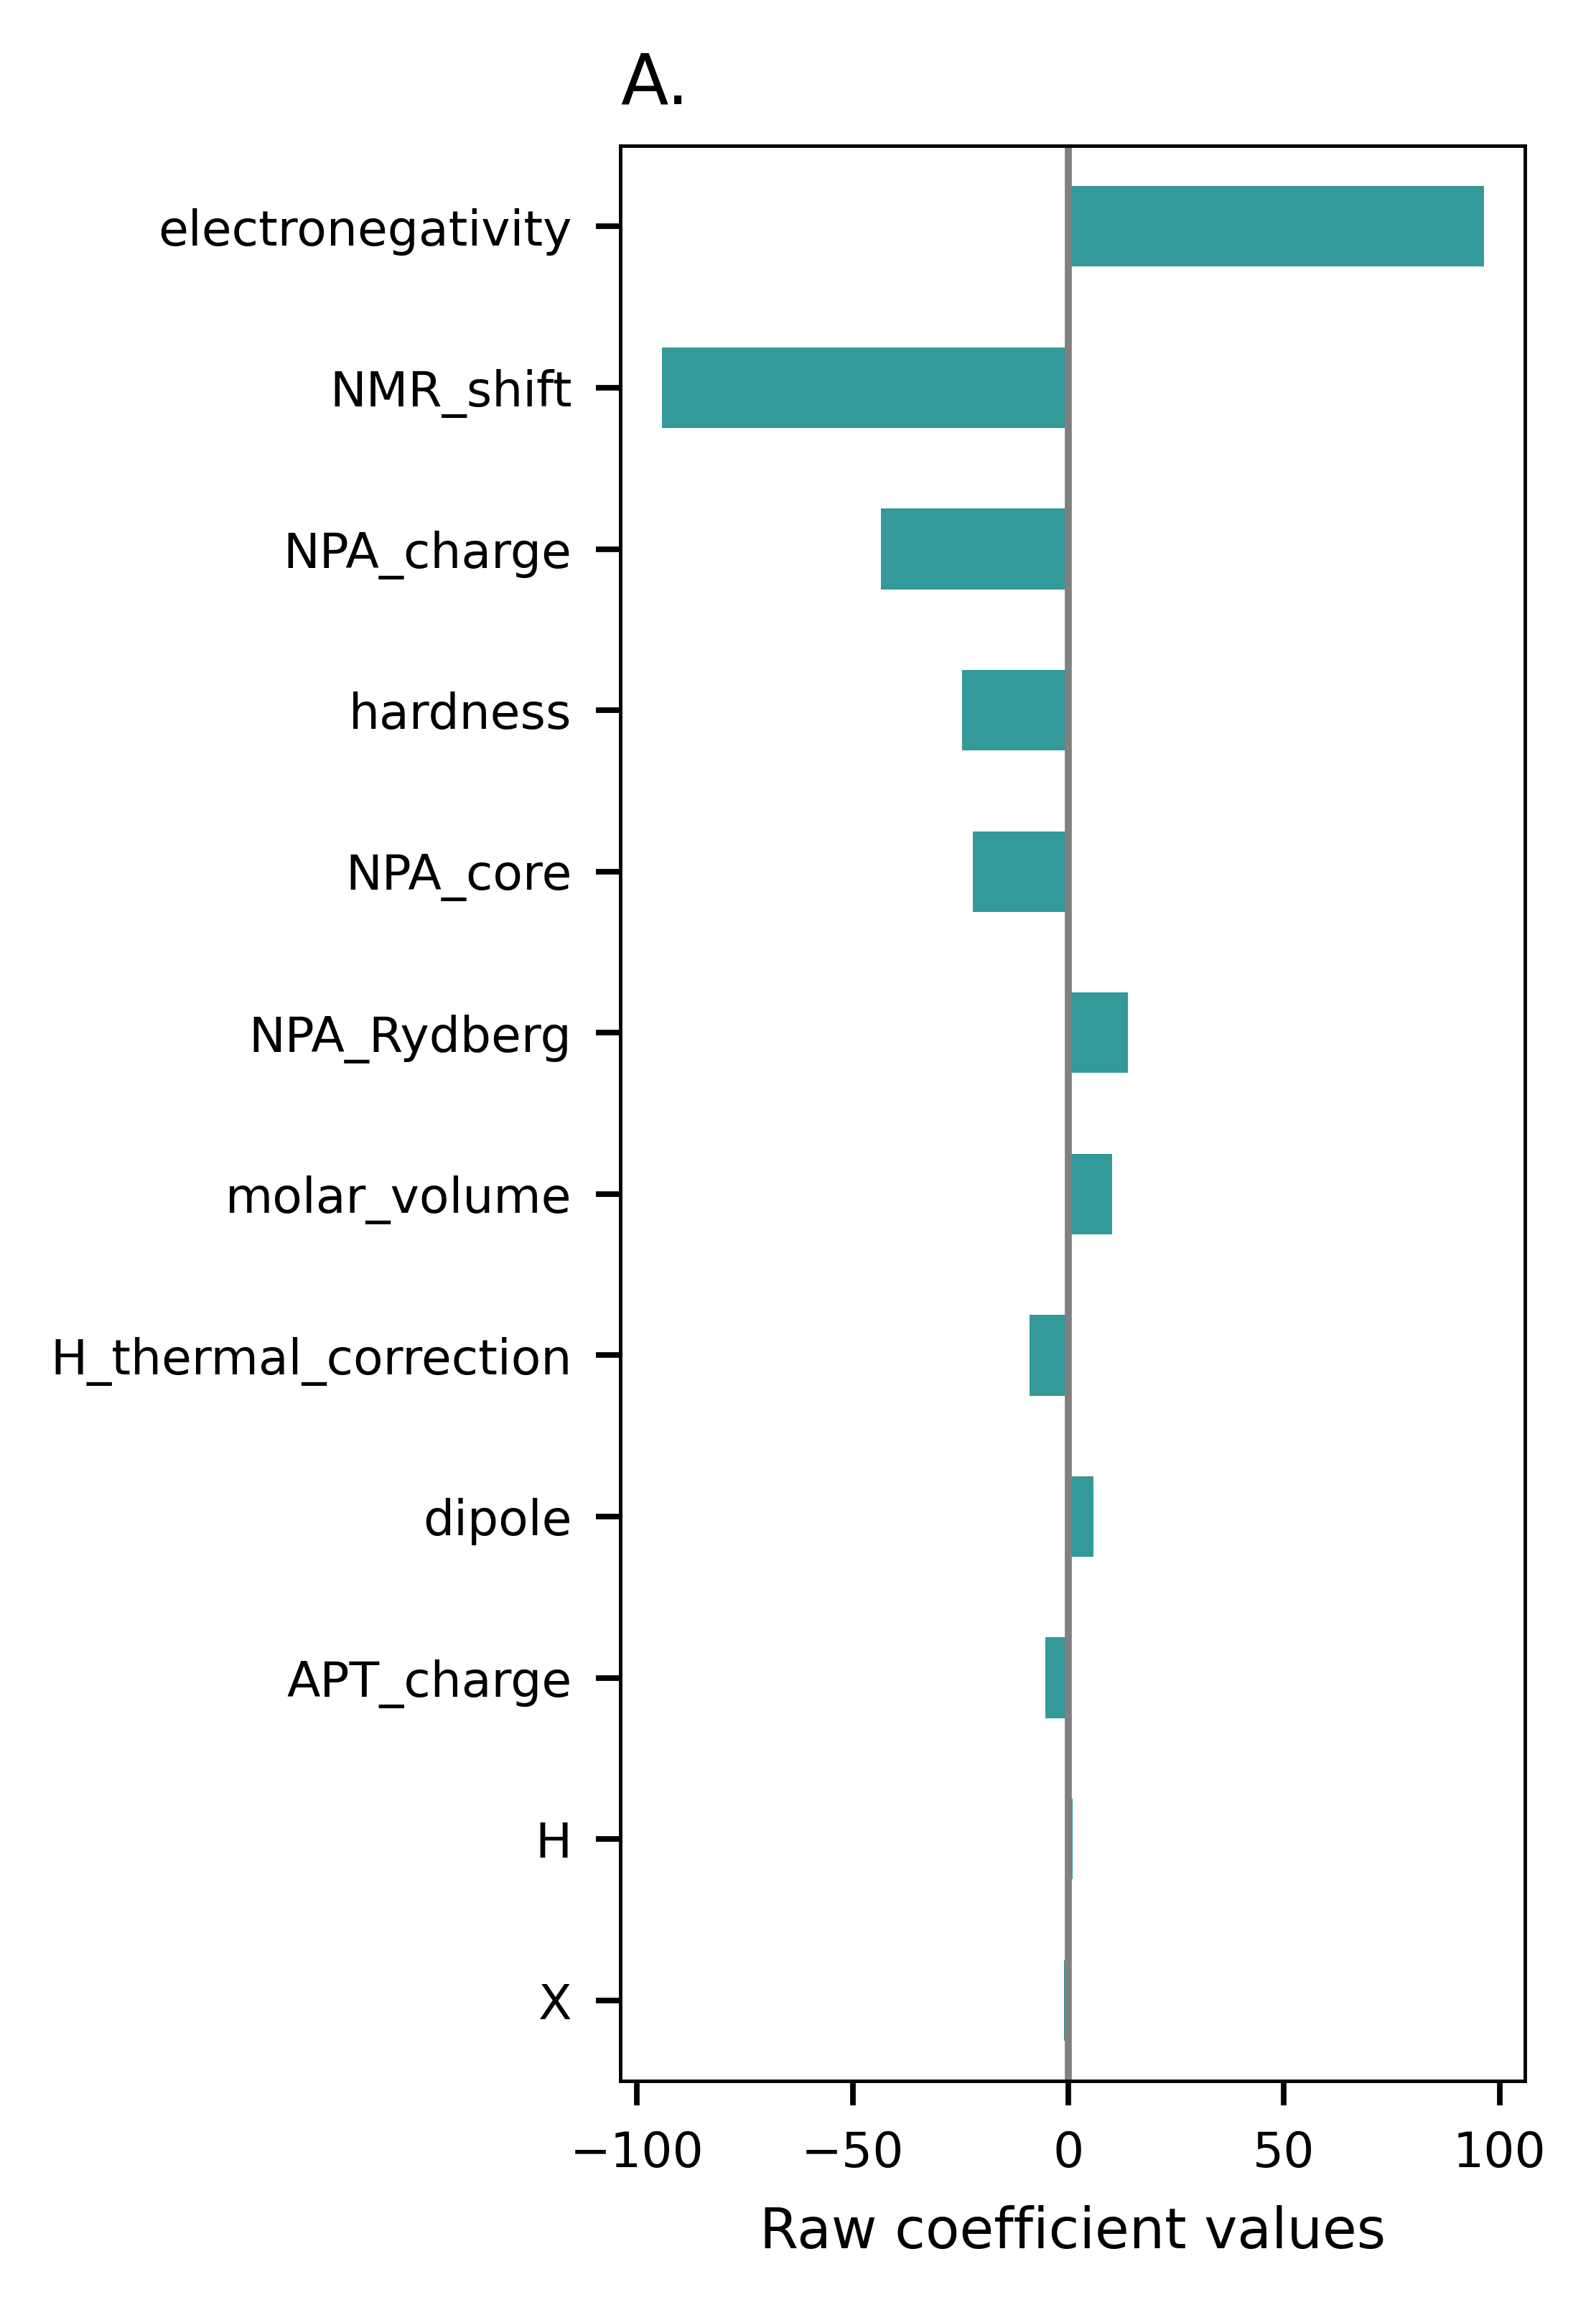

In [199]:
fig, ax = plt.subplots(figsize=(3, 5))

more_important_coefs["Coefficients"].plot.barh(color = 'teal', alpha = 0.8)
ax.set_title('A.', loc='left', fontsize =10)
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

fig.savefig(f'article/figures/coefficients_ridge_model.svg', facecolor = 'white', format = 'svg', transparent = True, bbox_inches='tight')

## Permutation importance

#### Choosing uncorrelated features

#### generate descriptors and choose model

In [112]:
df_X_perm = df_X.loc[:,uncorrelated_features]
X_perm = np.array(df_X_perm)
Y = df_total.FIA
model = dict_models["GB"]['quantum']
n_rep = 10

In [ ]:
scores = evaluate_model(model, X_perm, Y, n_rep =10)

np.mean(scores)

In [20]:
df = pd.DataFrame(columns = dict_models.keys(), index = ["quantum"])

In [21]:
for model in df.columns: 
            print(model)
            try : 
                scores = evaluate_model(dict_models[model]['quantum'], X_perm,Y, n_rep = 10)
                for i,elt in enumerate(scores) : 
                    if elt < -100:
                        scores = np.delete(scores,[0,i])
                        print('split diverged')
                MAE = abs(round(np.mean(scores),2))
                df.at["quantum",model] = MAE
            except: df.at[descriptor, model] = "dv"

Linear
Ridge
BayesRidge
Lasso
SVR
Tree
RF
GB
GPR
KNN
MLP


In [24]:
df

Linear  Ridge BayesRidge  Lasso    SVR   Tree     RF     GB    GPR  \
quantum  21.49  21.71      21.54  21.49  22.08  21.28  16.13  14.83  21.67   

           KNN    MLP  
quantum  21.76  21.49

In [25]:
df.to_excel('article/tables/MAE_models_quatum_descriptors_permutation_importance.xlsx')

RF & GB perform best

#### Permutation importance

In [84]:
from sklearn.inspection import permutation_importance

def get_mean_importances(model, n_rep, n_fold, X, Y, input_features):
    Pi = []
    
    for i in range(n_rep):
        
        KF = KFold(n_splits=n_fold, shuffle=True)#pas fixer le random state sinon il fait les meme split a chaque n_rep
        for i, (train_index, test_index) in enumerate(KF.split(X,Y)):
            X_train = X[train_index]
            X_test = X[test_index]
            Y_train = Y[train_index]
            Y_test = Y[test_index]
            scaler = StandardScaler().fit(X_train) ## descriptors are scaled
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)    
            selector = VarianceThreshold()
            selector.fit(X_train) ## features that have same value 
            X_train = selector.transform(X_train)# for every molecule are eliminated
            X_test = selector.transform(X_test)
            feature_names = selector.get_feature_names_out(input_features)#ne devrait pas changer au cours des repet
            model.fit(X_train, Y_train)
            pi = permutation_importance(model, X_train, Y_train, scoring=None, 
                                n_repeats=10, # nombre de fois que chaque feature est mélangée
                                max_samples=3.0)
            Pi.append(pi)
    
    mean_importances = np.zeros((len(feature_names)))
    std = np.zeros((len(feature_names)))
    for i in range(len(Pi)):
        mean_importances += Pi[i]['importances_mean']
        std += Pi[i]['importances_std']
    mean_importances = mean_importances/len(Pi) #on calcule la moyenne des moyennes
    std = std/len(Pi)
    
    return(feature_names, mean_importances, std )

def more_important_features_mean(mean_importances, std, feature_names, imp_min):
    
    
    restr_names   = []
    restr_imp = []
    restr_std = []
    for i,imp in enumerate(mean_importances):
        if imp > imp_min:
            restr_names.append(feature_names[i])
            restr_imp.append(imp)
            restr_std.append(std[i])
    plt.bar(restr_names, restr_imp, yerr = restr_std)
    plt.xticks(rotation=25, rotation_mode='default', ha = 'right')
    plt.ylabel('importance (%)')
    plt.margins(0.2)
    plt.tight_layout()
    plt.show()
    
    #fig.savefig('figures/permutation_importance/important_params_quantum.png', transparent = False, format = 'png')
    
    return restr_names, restr_imp, restr_std

In [122]:
model_perm = dict_models["GB"]['quantum']

In [125]:
feature_names, mean_importances, std = get_mean_importances(model_perm, 10, 10, X_uncor, Y, uncorrelated_features)

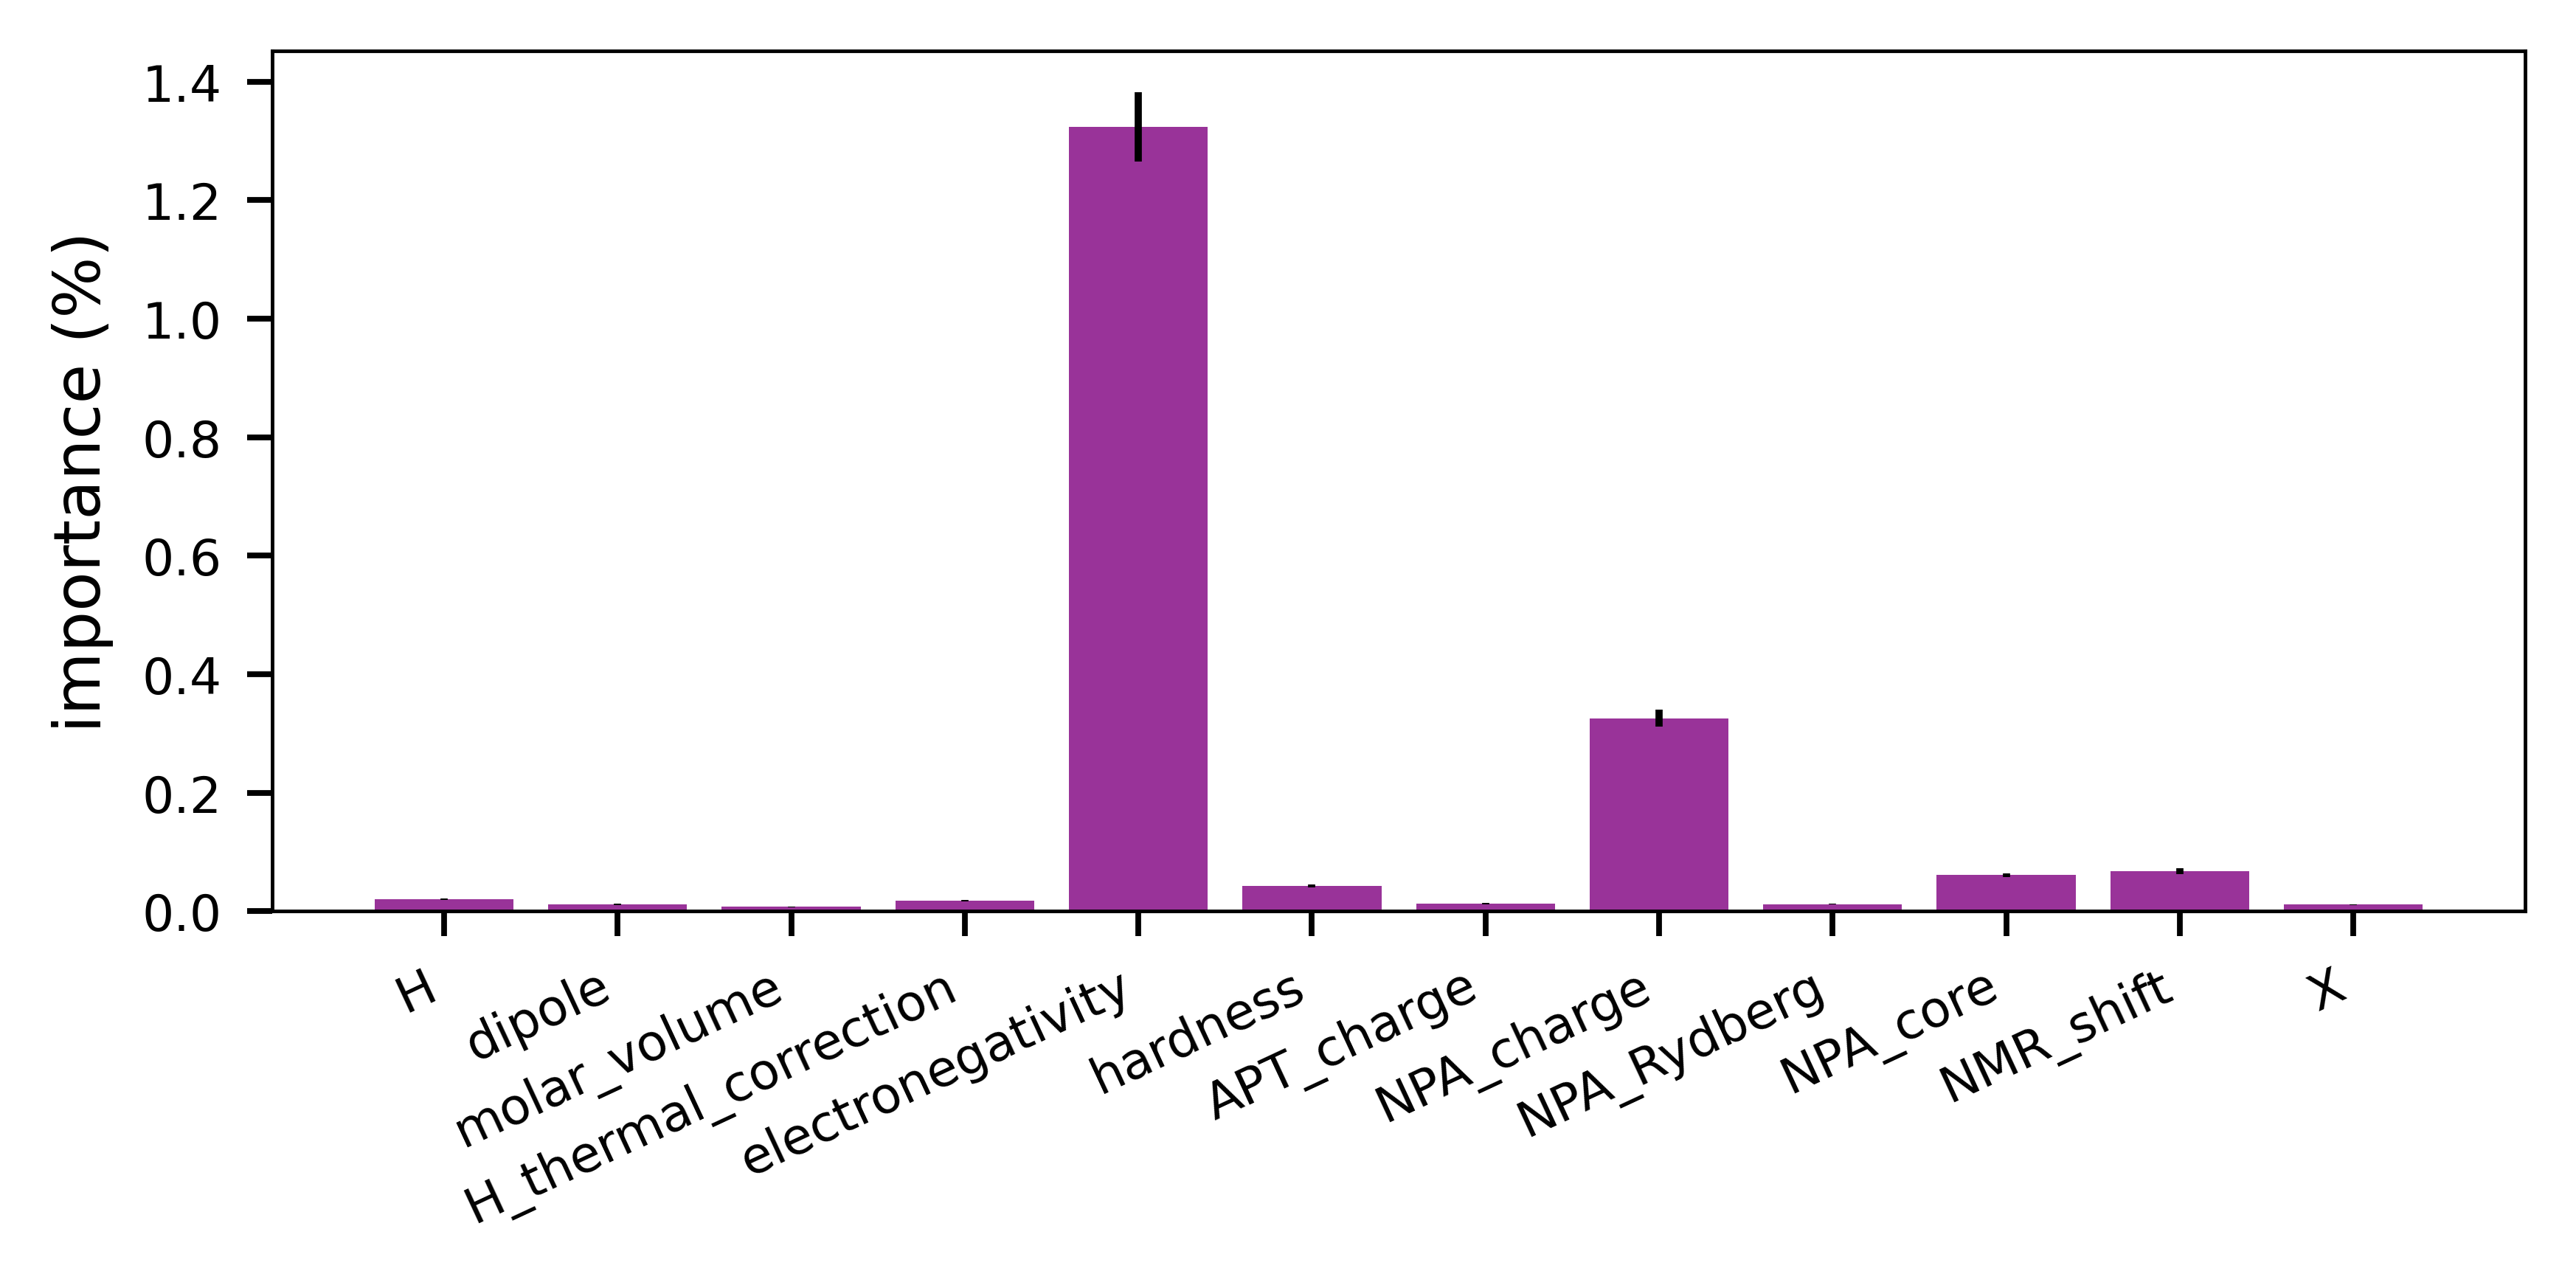

In [126]:

fig, ax = plt.subplots(figsize=(5,2.5))

plt.bar(feature_names, mean_importances, yerr = std, color = 'purple', alpha = 0.8)

plt.xticks(rotation=25, rotation_mode='default', ha = 'right', fontsize = 7)
#ax.set_title('C.', loc='left', fontsize =10)
plt.ylabel('importance (%)', size = 9)
#plt.margins(0.2)
plt.tight_layout()
plt.show()

#fig.savefig(f'article/figures/permutation_importance_quantum_Ridge.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')
    

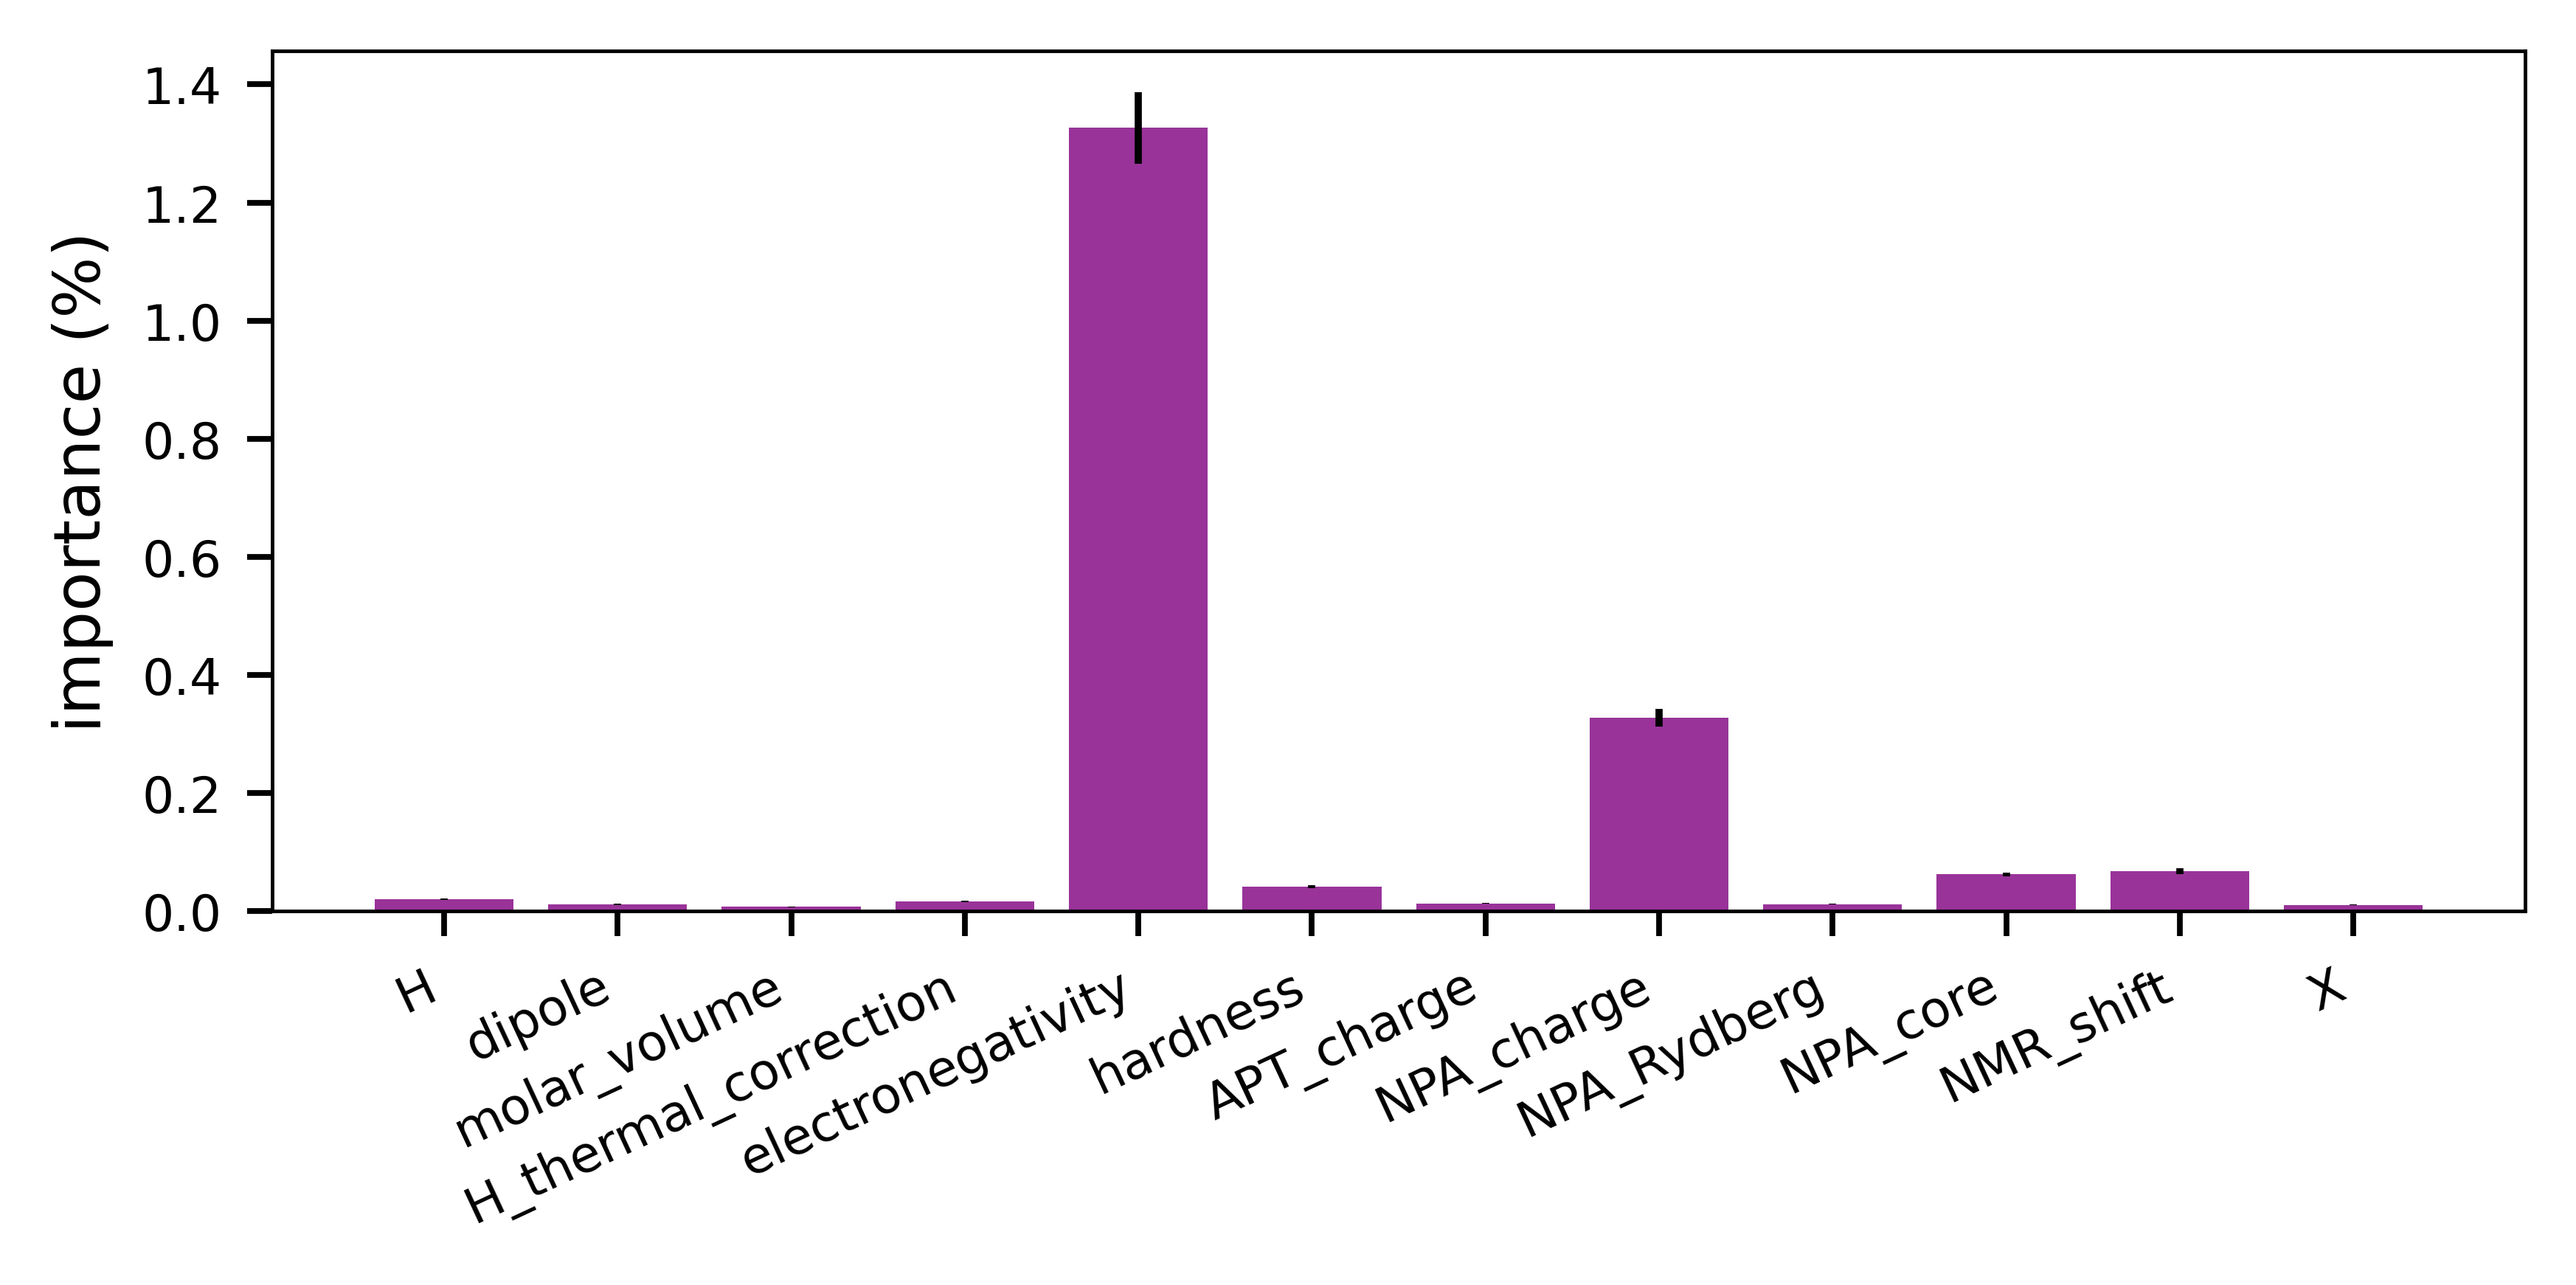

In [92]:

fig, ax = plt.subplots(figsize=(5,2.5))

plt.bar(feature_names, mean_importances, yerr = std, color = 'purple', alpha = 0.8)

plt.xticks(rotation=25, rotation_mode='default', ha = 'right', fontsize = 7)
#ax.set_title('C.', loc='left', fontsize =10)
plt.ylabel('importance (%)', size = 9)
#plt.margins(0.2)
plt.tight_layout()
plt.show()

#fig.savefig(f'article/figures/permutation_importance_quantum_Ridge.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')
    

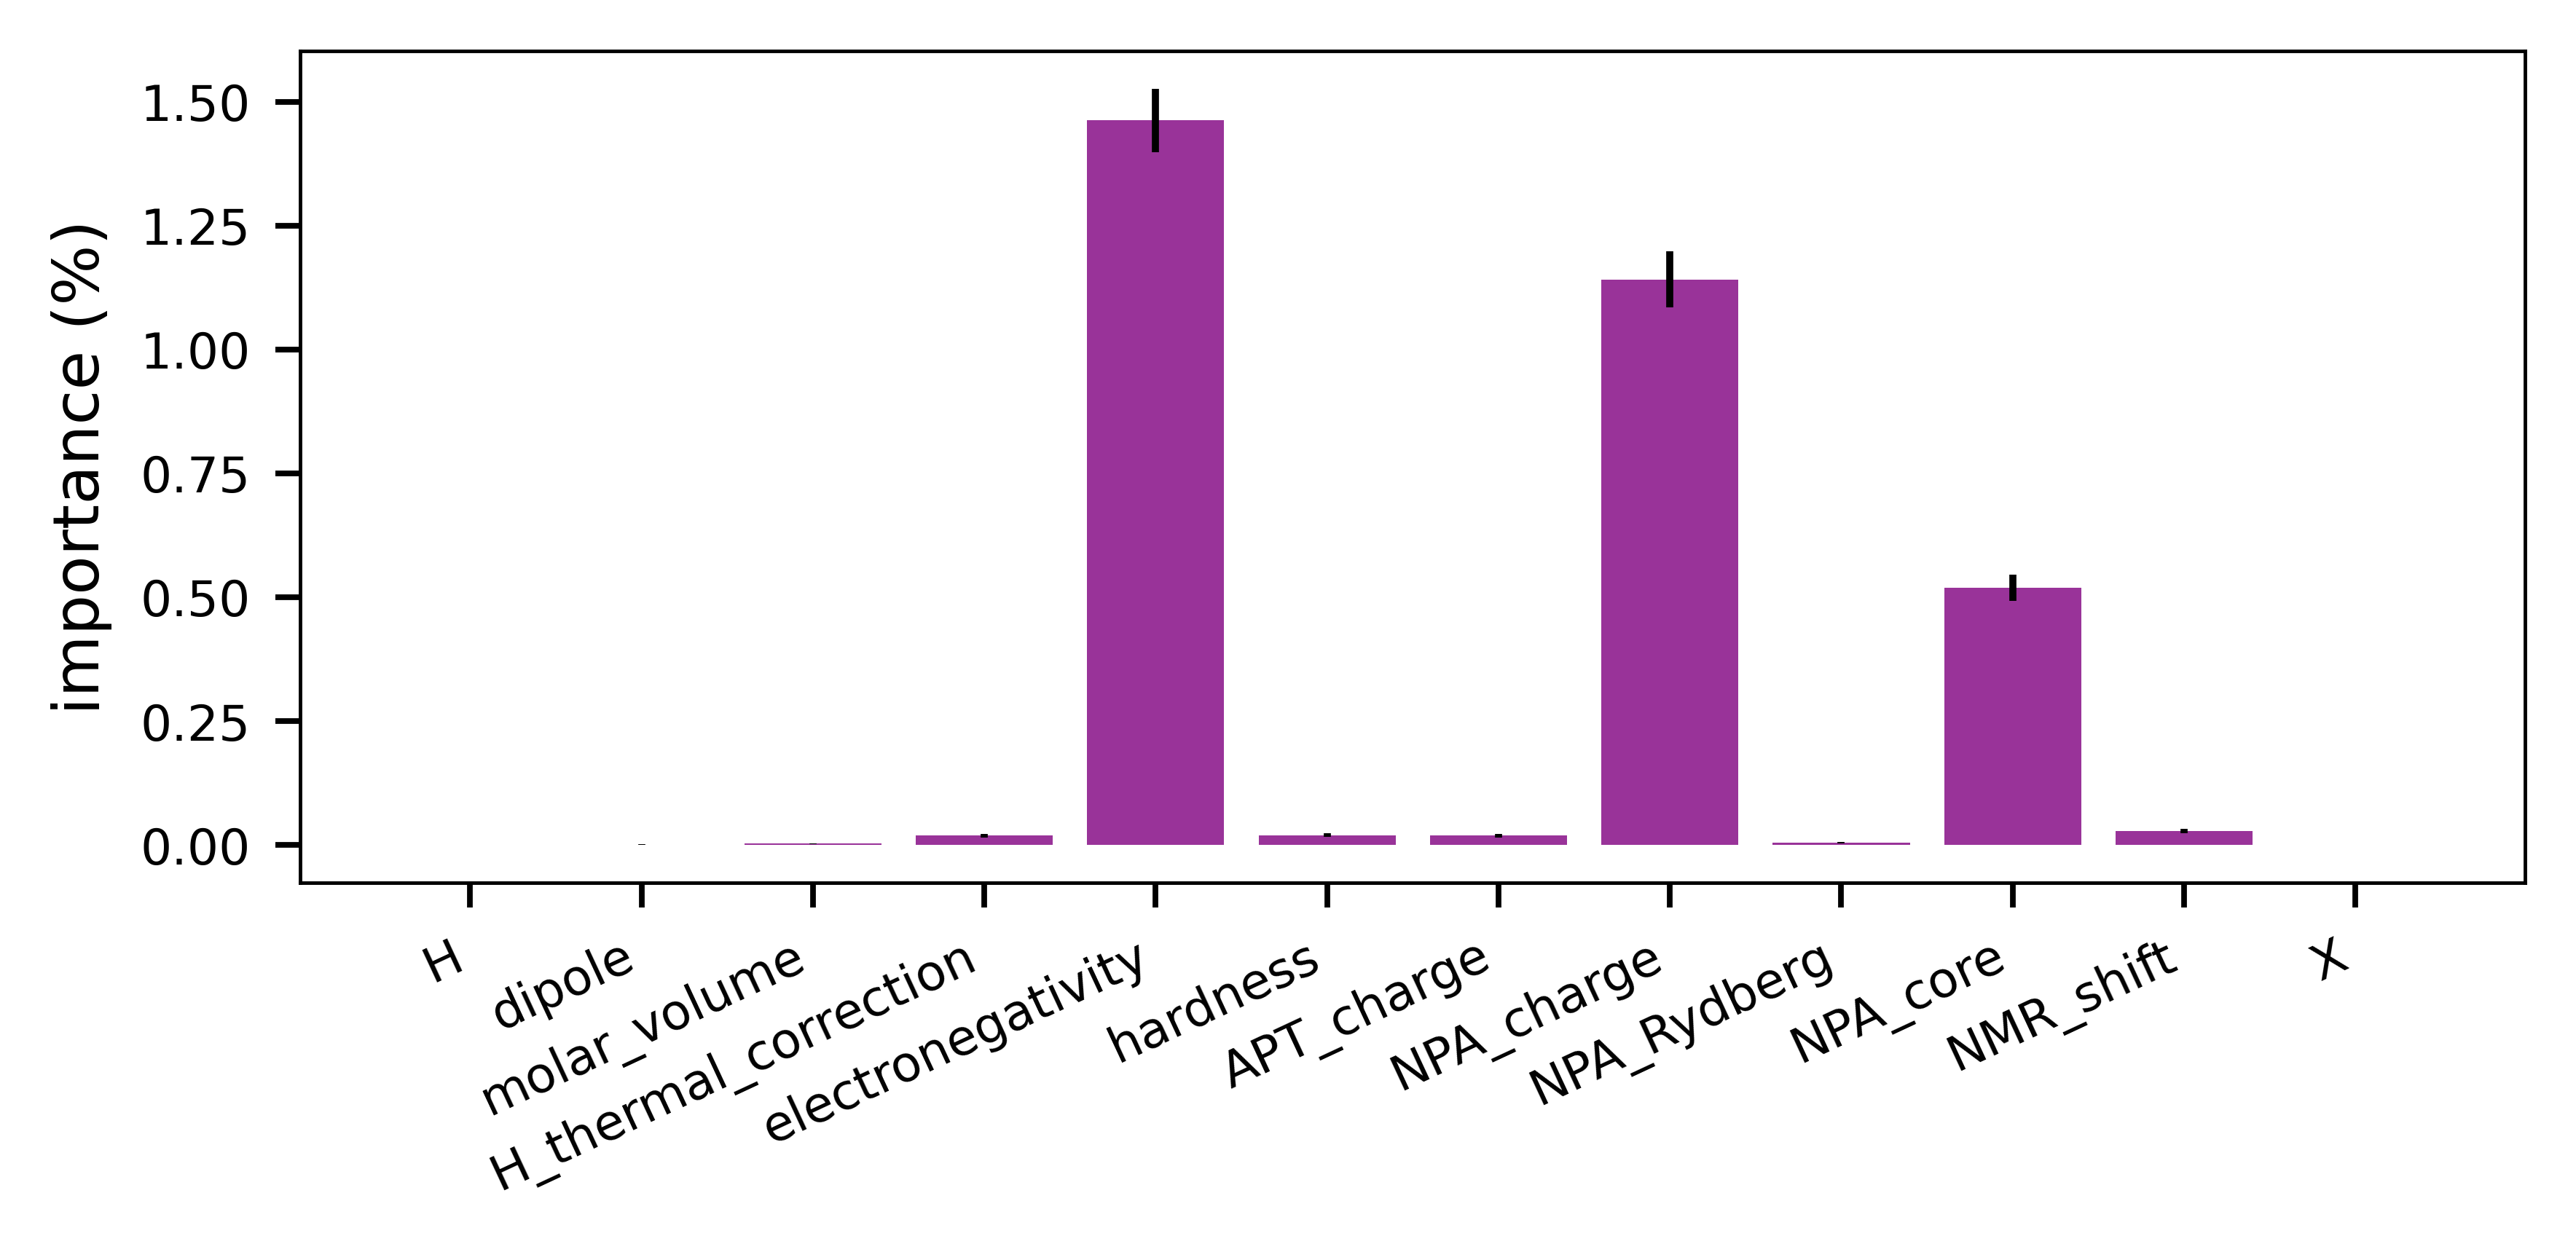

In [37]:

fig, ax = plt.subplots(figsize=(5,2.5))

plt.bar(feature_names, mean_importances, yerr = std, color = 'purple', alpha = 0.8)

plt.xticks(rotation=25, rotation_mode='default', ha = 'right', fontsize = 7)
#ax.set_title('C.', loc='left', fontsize =10)
plt.ylabel('importance (%)', size = 9)
#plt.margins(0.2)
plt.tight_layout()
plt.show()

#fig.savefig(f'article/figures/permutation_importance_quantum_Ridge.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')
    

## Poster

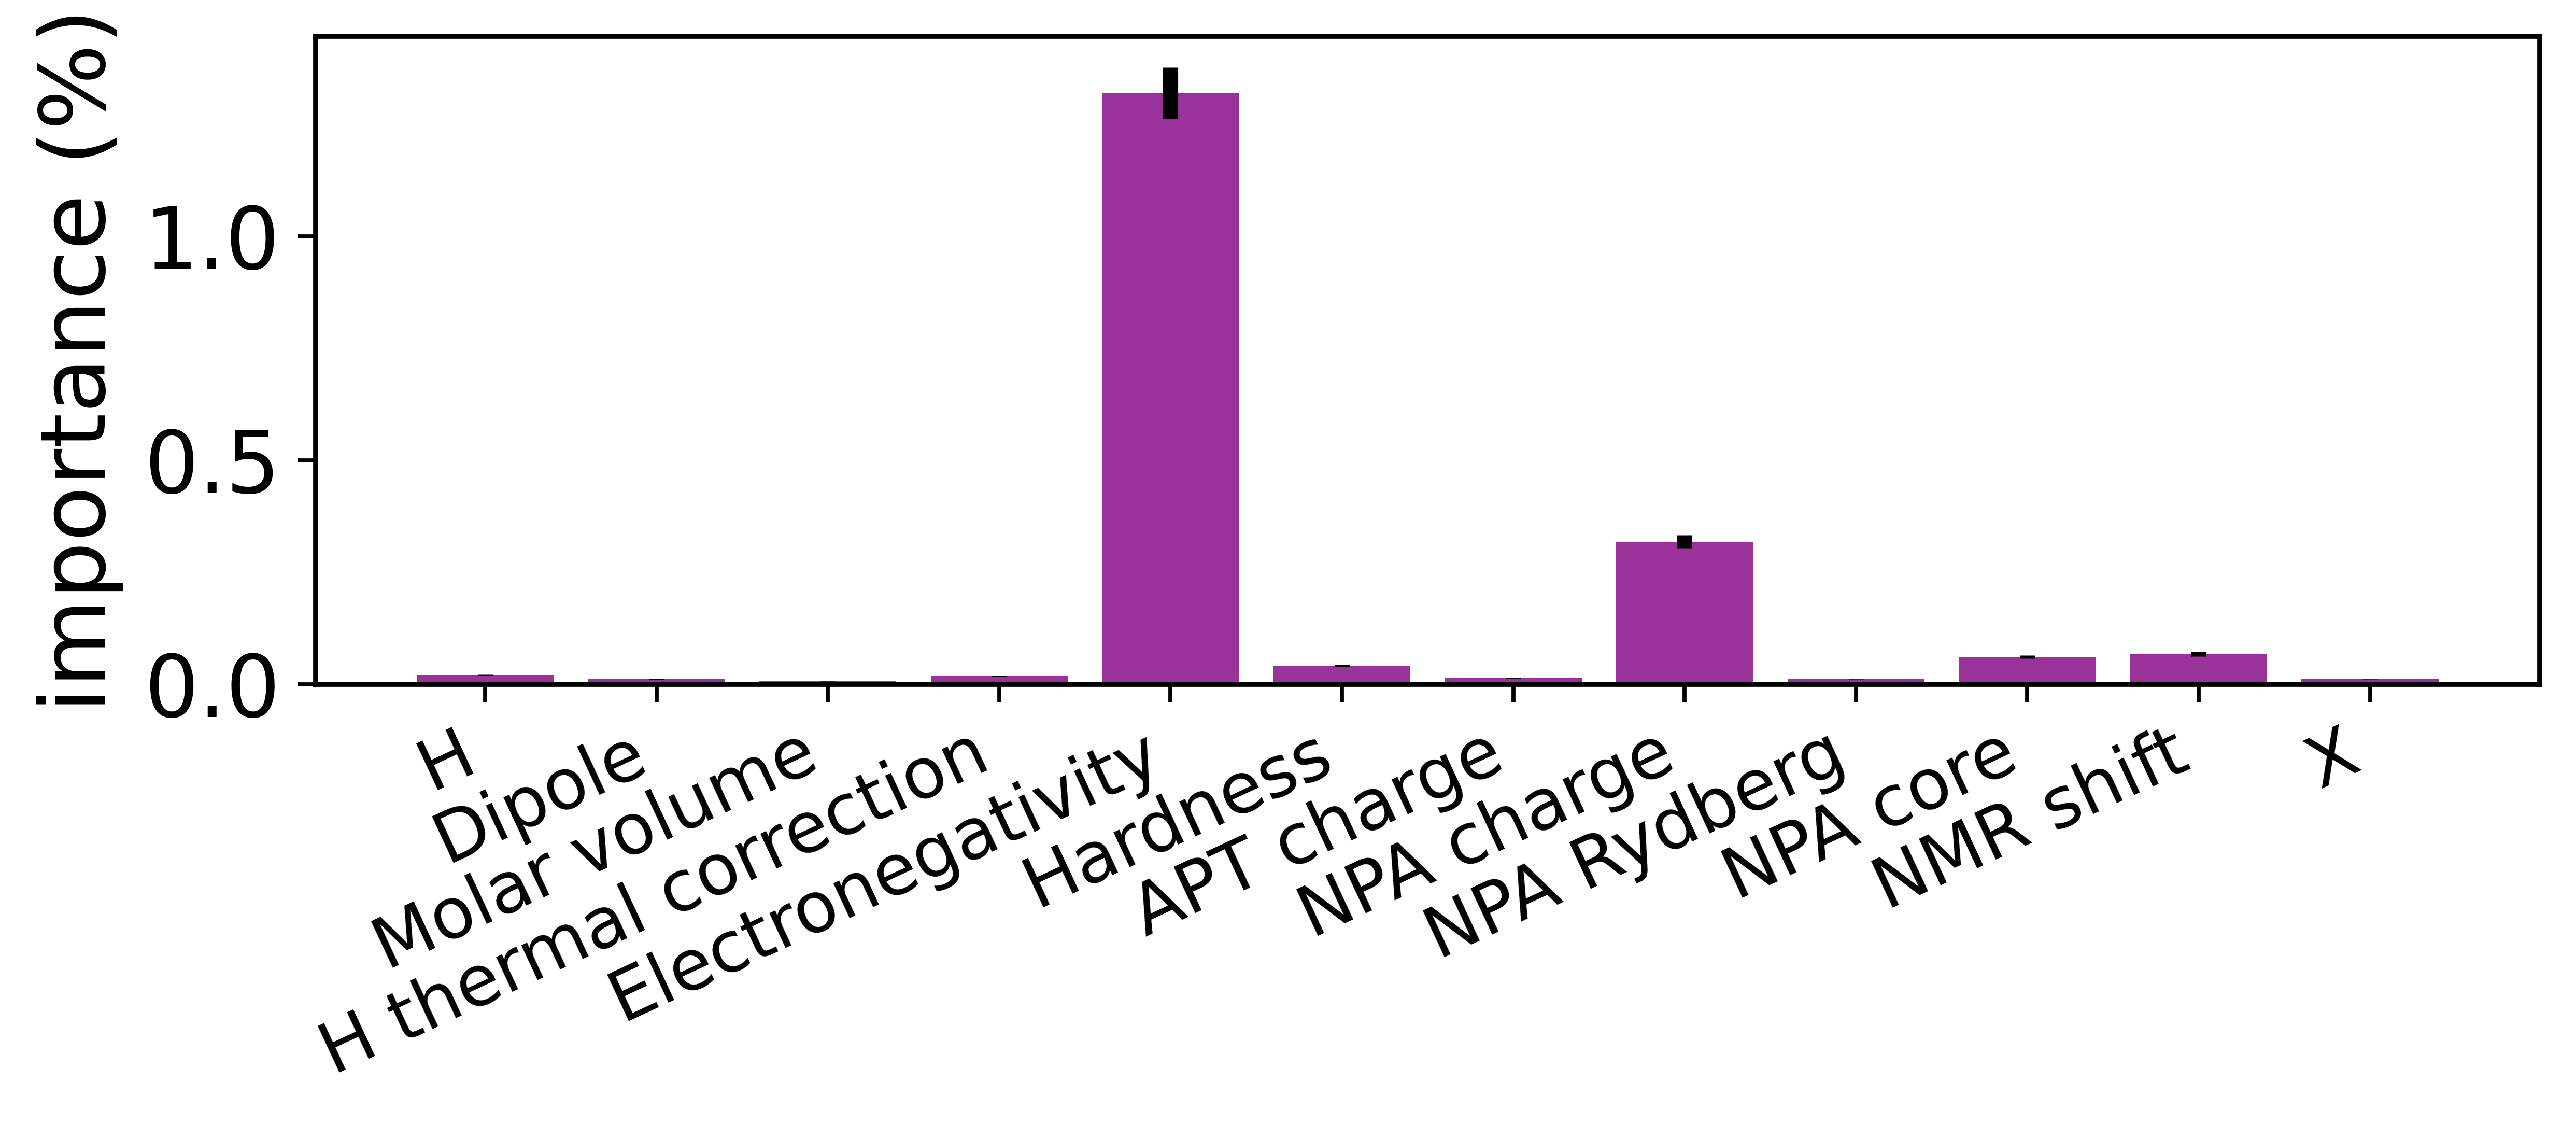

In [28]:
#params poster
rc('font', family='sans-serif', size = 20)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 17)
rc('legend', fontsize=15)
rc('lines', linewidth = 3)
rc('axes', linewidth = 1)
rc('legend', handlelength = 2)


fig, ax = plt.subplots(figsize=(7.5,3.5))

ticks = ['H', 'Dipole', 'Molar volume', 'H thermal correction', "Electronegativity", "Hardness", "APT charge", "NPA charge", "NPA Rydberg", 'NPA core', 'NMR shift', 'X'] 

plt.bar(ticks, mean_importances, yerr = std, color = 'purple', alpha = 0.8 )


plt.xticks(rotation=25, rotation_mode='default', ha = 'right' , fontsize = 14)
#ax.set_title('C.', loc='left', fontsize =10)
plt.ylabel('importance (%)', fontsize =18)
#plt.margins(0.2)
plt.tight_layout()
plt.show()

fig.savefig(f'figures/poster/permutation_importance_quantum_GB.svg', format = 'svg', transparent = True, bbox_inches='tight')
    

In [36]:
df = pd.DataFrame()
df['features'] = feature_names
df['mean importance']=mean_importances
df['standard deviation']=std

df =df.set_index('features')
df = df.sort_values('mean importance', ascending = False)

df.to_excel('article/tables/importances_of_quantum_features_ridge.xlsx')


### Plot final figure

In [139]:
		rc('font', family='sans-serif', size = 7)
		rc('figure', dpi= 700)
		rc(('xtick', 'ytick'), labelsize = 7)
		rc('legend', fontsize=5)
		rc('lines', linewidth = 1)
		rc('axes', linewidth = 0.5, labelsize =8)
		rc('legend', handlelength = 2)


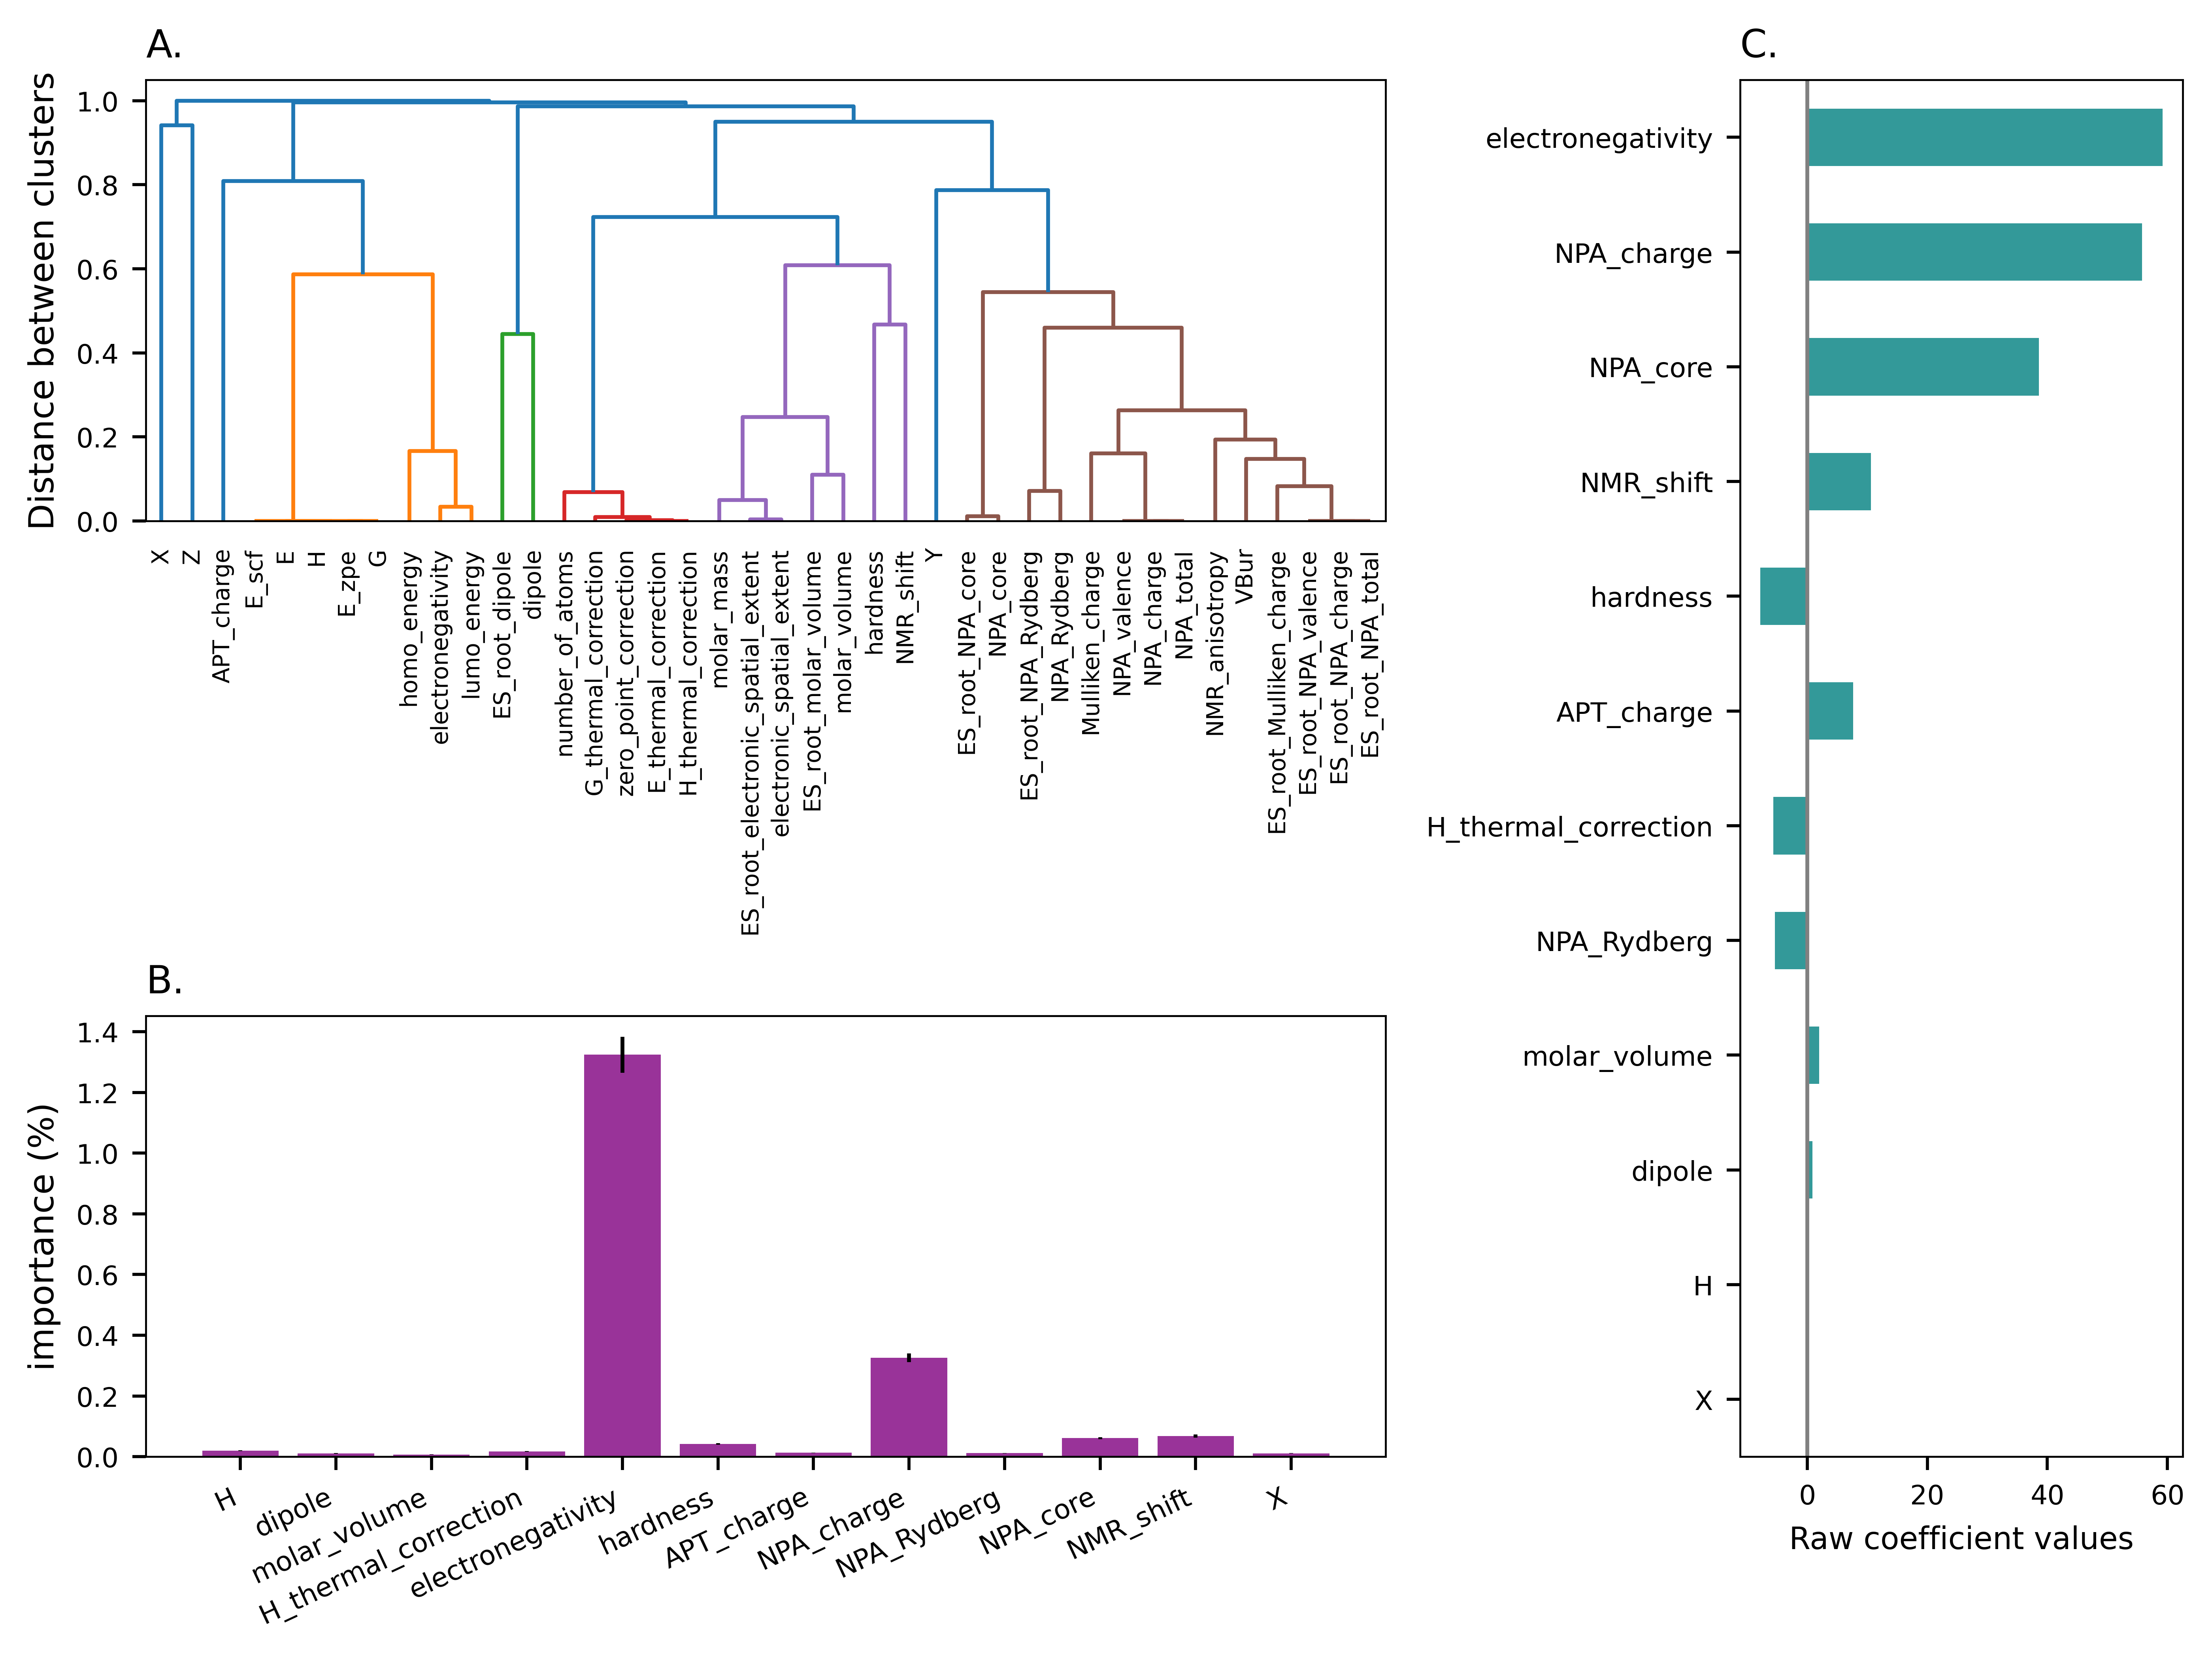

In [140]:
fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot2grid((2, 3), (0, 2), rowspan = 2)

ax2 = plt.subplot2grid((2, 3), (0, 0), colspan = 2)
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan = 2)


more_important_coefs["Coefficients"].plot.barh(color = 'teal', alpha = 0.8, ax = ax1)
ax1.set_title('C.', loc='left', fontsize =10)
ax1.axvline(x=0, color=".5")
ax1.set_xlabel("Raw coefficient values")
#plt.subplots_adjust(left=0.3)





dendrogram = hierarchy.dendrogram(Z, labels=df_X.columns, orientation='top', 
           leaf_rotation=90, leaf_font_size = 6, ax = ax2);

ax2.set_ylabel("Distance between clusters", size = 9)
ax2.set_title('A.', loc='left', fontsize =10)


ax3.bar(feature_names, mean_importances, yerr = std, color = 'purple', alpha = 0.8)

plt.xticks(rotation=25, rotation_mode='default', ha = 'right', fontsize = 7)
ax3.set_title('B.', loc='left', fontsize =10)
ax3.set_ylabel('importance (%)', size = 9)
#plt.margins(0.2)



plt.tight_layout(w_pad = 1.5)


fig.savefig(f'article/figures/lewis_acidity_interpretability.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

In [145]:
df_X.NPA_core.std()

0.00016433017698321868

In [147]:
df_total['group']

SMILES
c1ccc2c(c1)OB1Oc3ccccc3-c3cccc-2c31                                                               Ohmiya
CC(C)(C)c1cc(Cl)c2c(c1)-c1cc(Cl)cc3c1B(O2)Oc1c(Cl)cc(C(C)(C)C)cc1-3                               Ohmiya
CC(C)(C)c1cc(F)c2c(c1)-c1cc(N)cc3c1B(O2)Oc1c(F)cc(C(C)(C)C)cc1-3                                  Ohmiya
CC(C)(C)c1cc2c(c([N+](=O)[O-])c1)OB1Oc3c(cc(C(C)(C)C)cc3[N+](=O)[O-])-c3cc(C#N)cc-2c31            Ohmiya
CC(C)(C)c1cc2c3c(c1)-c1cc(C#N)cc(C(C)(C)C)c1OB3Oc1c-2cc(C#N)cc1C(C)(C)C                           Ohmiya
                                                                                               ...      
Oc1cc(B(c2cc(O)c(Cl)c(O)c2)c2cc(O)c(Cl)c(O)c2)cc(O)c1Cl                                   triarylboranes
Oc1cc(B(c2cc(O)c(O)c(O)c2)c2cc(O)c(O)c(O)c2)cc(O)c1O                                      triarylboranes
Oc1cc(O)cc(B(c2cc(O)cc(O)c2)c2cc(O)cc(O)c2)c1                                             triarylboranes
Oc1ccc(B(c2ccc(O)cc2)c2ccc(O)cc2)cc1            

In [188]:
df_X['group']=list(df_total.group)

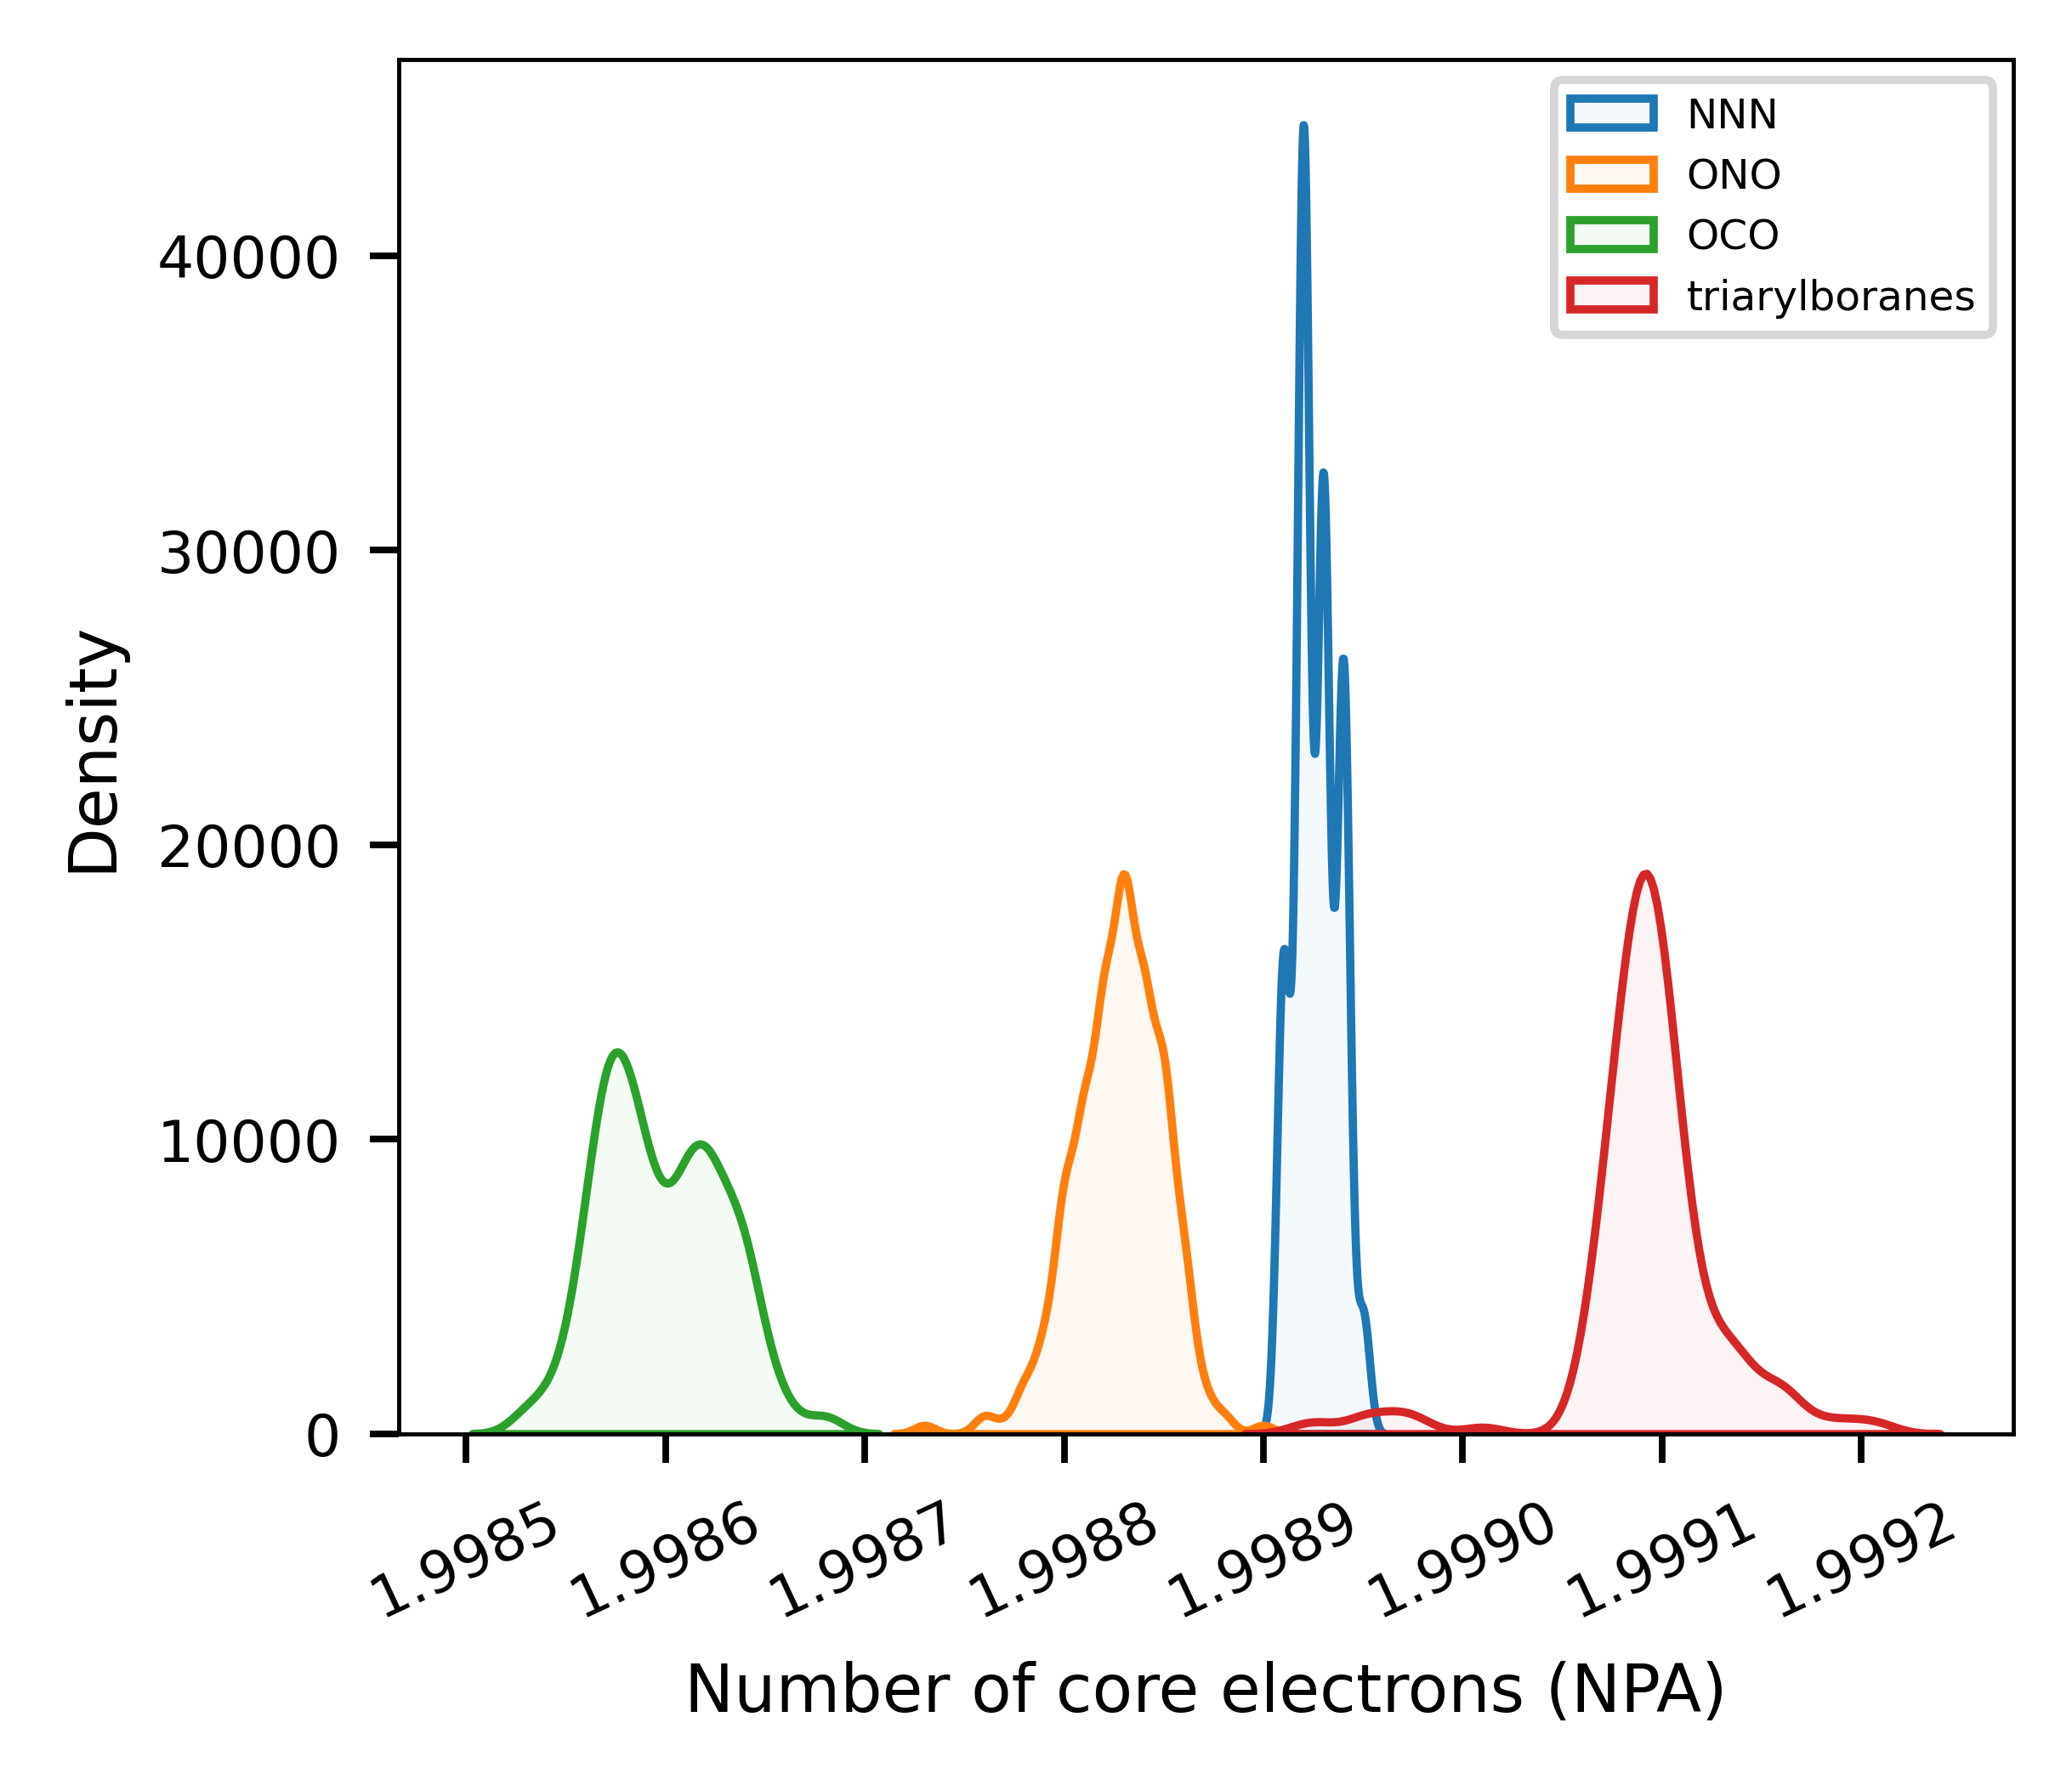

In [192]:
#sns.displot(df_total, x="FIA", kind ='kde', bw_adjust = 0.7, hue = 'group')
fig = plt.figure(figsize=(3.5, 3))

ax = fig.add_subplot()


bandwidth = 0.7
sns.kdeplot(df_X[df_X.group == 'NNN'], x="NPA_core", bw_adjust = bandwidth, label = 'NNN', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'ONO'], x="NPA_core", bw_adjust = bandwidth, label = 'ONO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'Ohmiya'], x="NPA_core", bw_adjust = bandwidth, label = 'OCO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'triarylboranes'], x="NPA_core", bw_adjust = bandwidth, label = 'triarylboranes', fill =True, alpha=0.05, ax = ax)

ax.set_xlabel('Number of core electrons (NPA)')

ax.tick_params(axis = 'x',rotation=25)
ax.legend()

fig.savefig('article/figures/DB_distribution_of_NPA_core.png', format='png', transparent= True, facecolor='white', bbox_inches='tight')

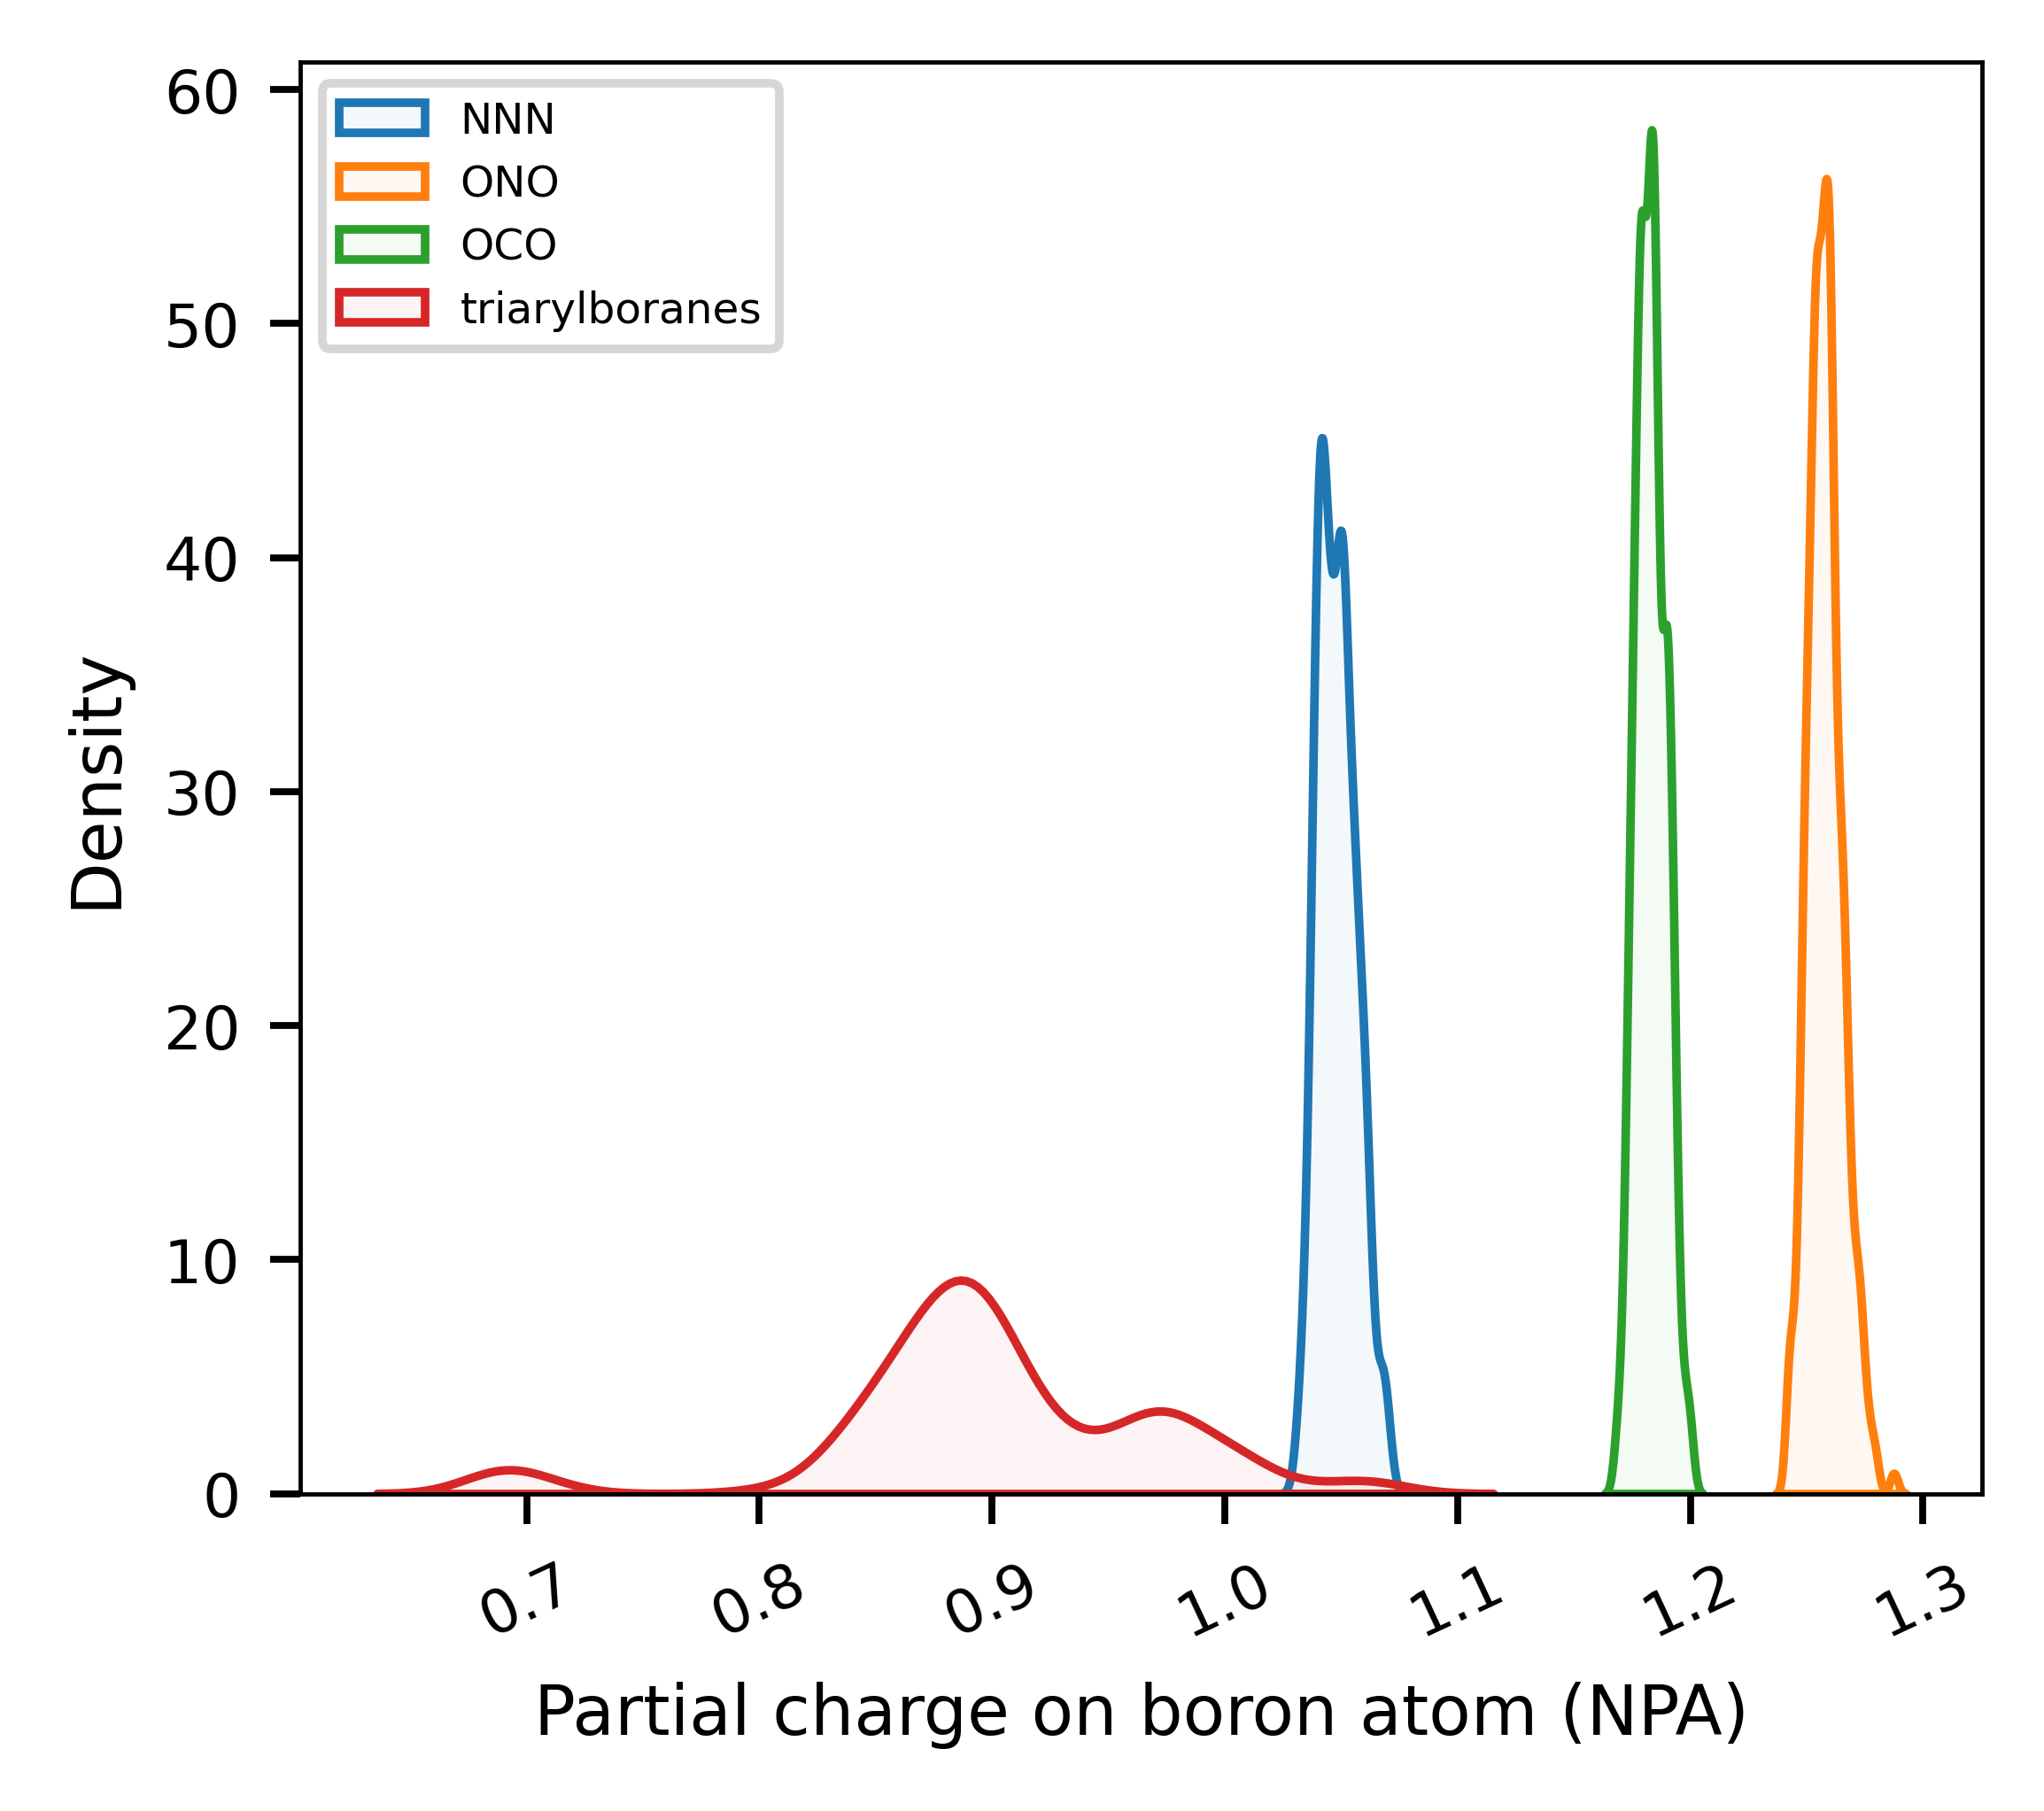

In [191]:
#sns.displot(df_total, x="FIA", kind ='kde', bw_adjust = 0.7, hue = 'group')
fig = plt.figure(figsize=(3.5, 3))

ax = fig.add_subplot()


bandwidth = 0.7
sns.kdeplot(df_X[df_X.group == 'NNN'], x="NPA_charge", bw_adjust = bandwidth, label = 'NNN', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'ONO'], x="NPA_charge", bw_adjust = bandwidth, label = 'ONO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'Ohmiya'], x="NPA_charge", bw_adjust = bandwidth, label = 'OCO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'triarylboranes'], x="NPA_charge", bw_adjust = bandwidth, label = 'triarylboranes', fill =True, alpha=0.05, ax = ax)

ax.set_xlabel('Partial charge on boron atom (NPA)')

ax.tick_params(axis = 'x',rotation=25)
ax.legend(loc = 'upper left')

In [214]:
df_X.NPA_charge

0      1.26232
1      1.25445
2      1.25369
3      1.26033
4      1.25745
        ...   
267    1.25611
268    1.25200
269    1.24522
270    1.25311
271    1.24883
Name: NPA_charge, Length: 272, dtype: float64

## FIA as a function of absolute electronegativity and charge

In [5]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

norm = Normalize(vmin = 180, vmax = 610)
mappable = ScalarMappable(norm=norm, cmap='viridis')
colors = mappable.to_rgba(list(df_total.FIA))

In [7]:
X_ONO = create_descriptors(df_ONO.index, "quantum", data = data_Q_tot)
df_X_ONO = pd.DataFrame(X_ONO, columns = get_names('quantum'))
df_X_ONO['FIA']= list(df_ONO.FIA)

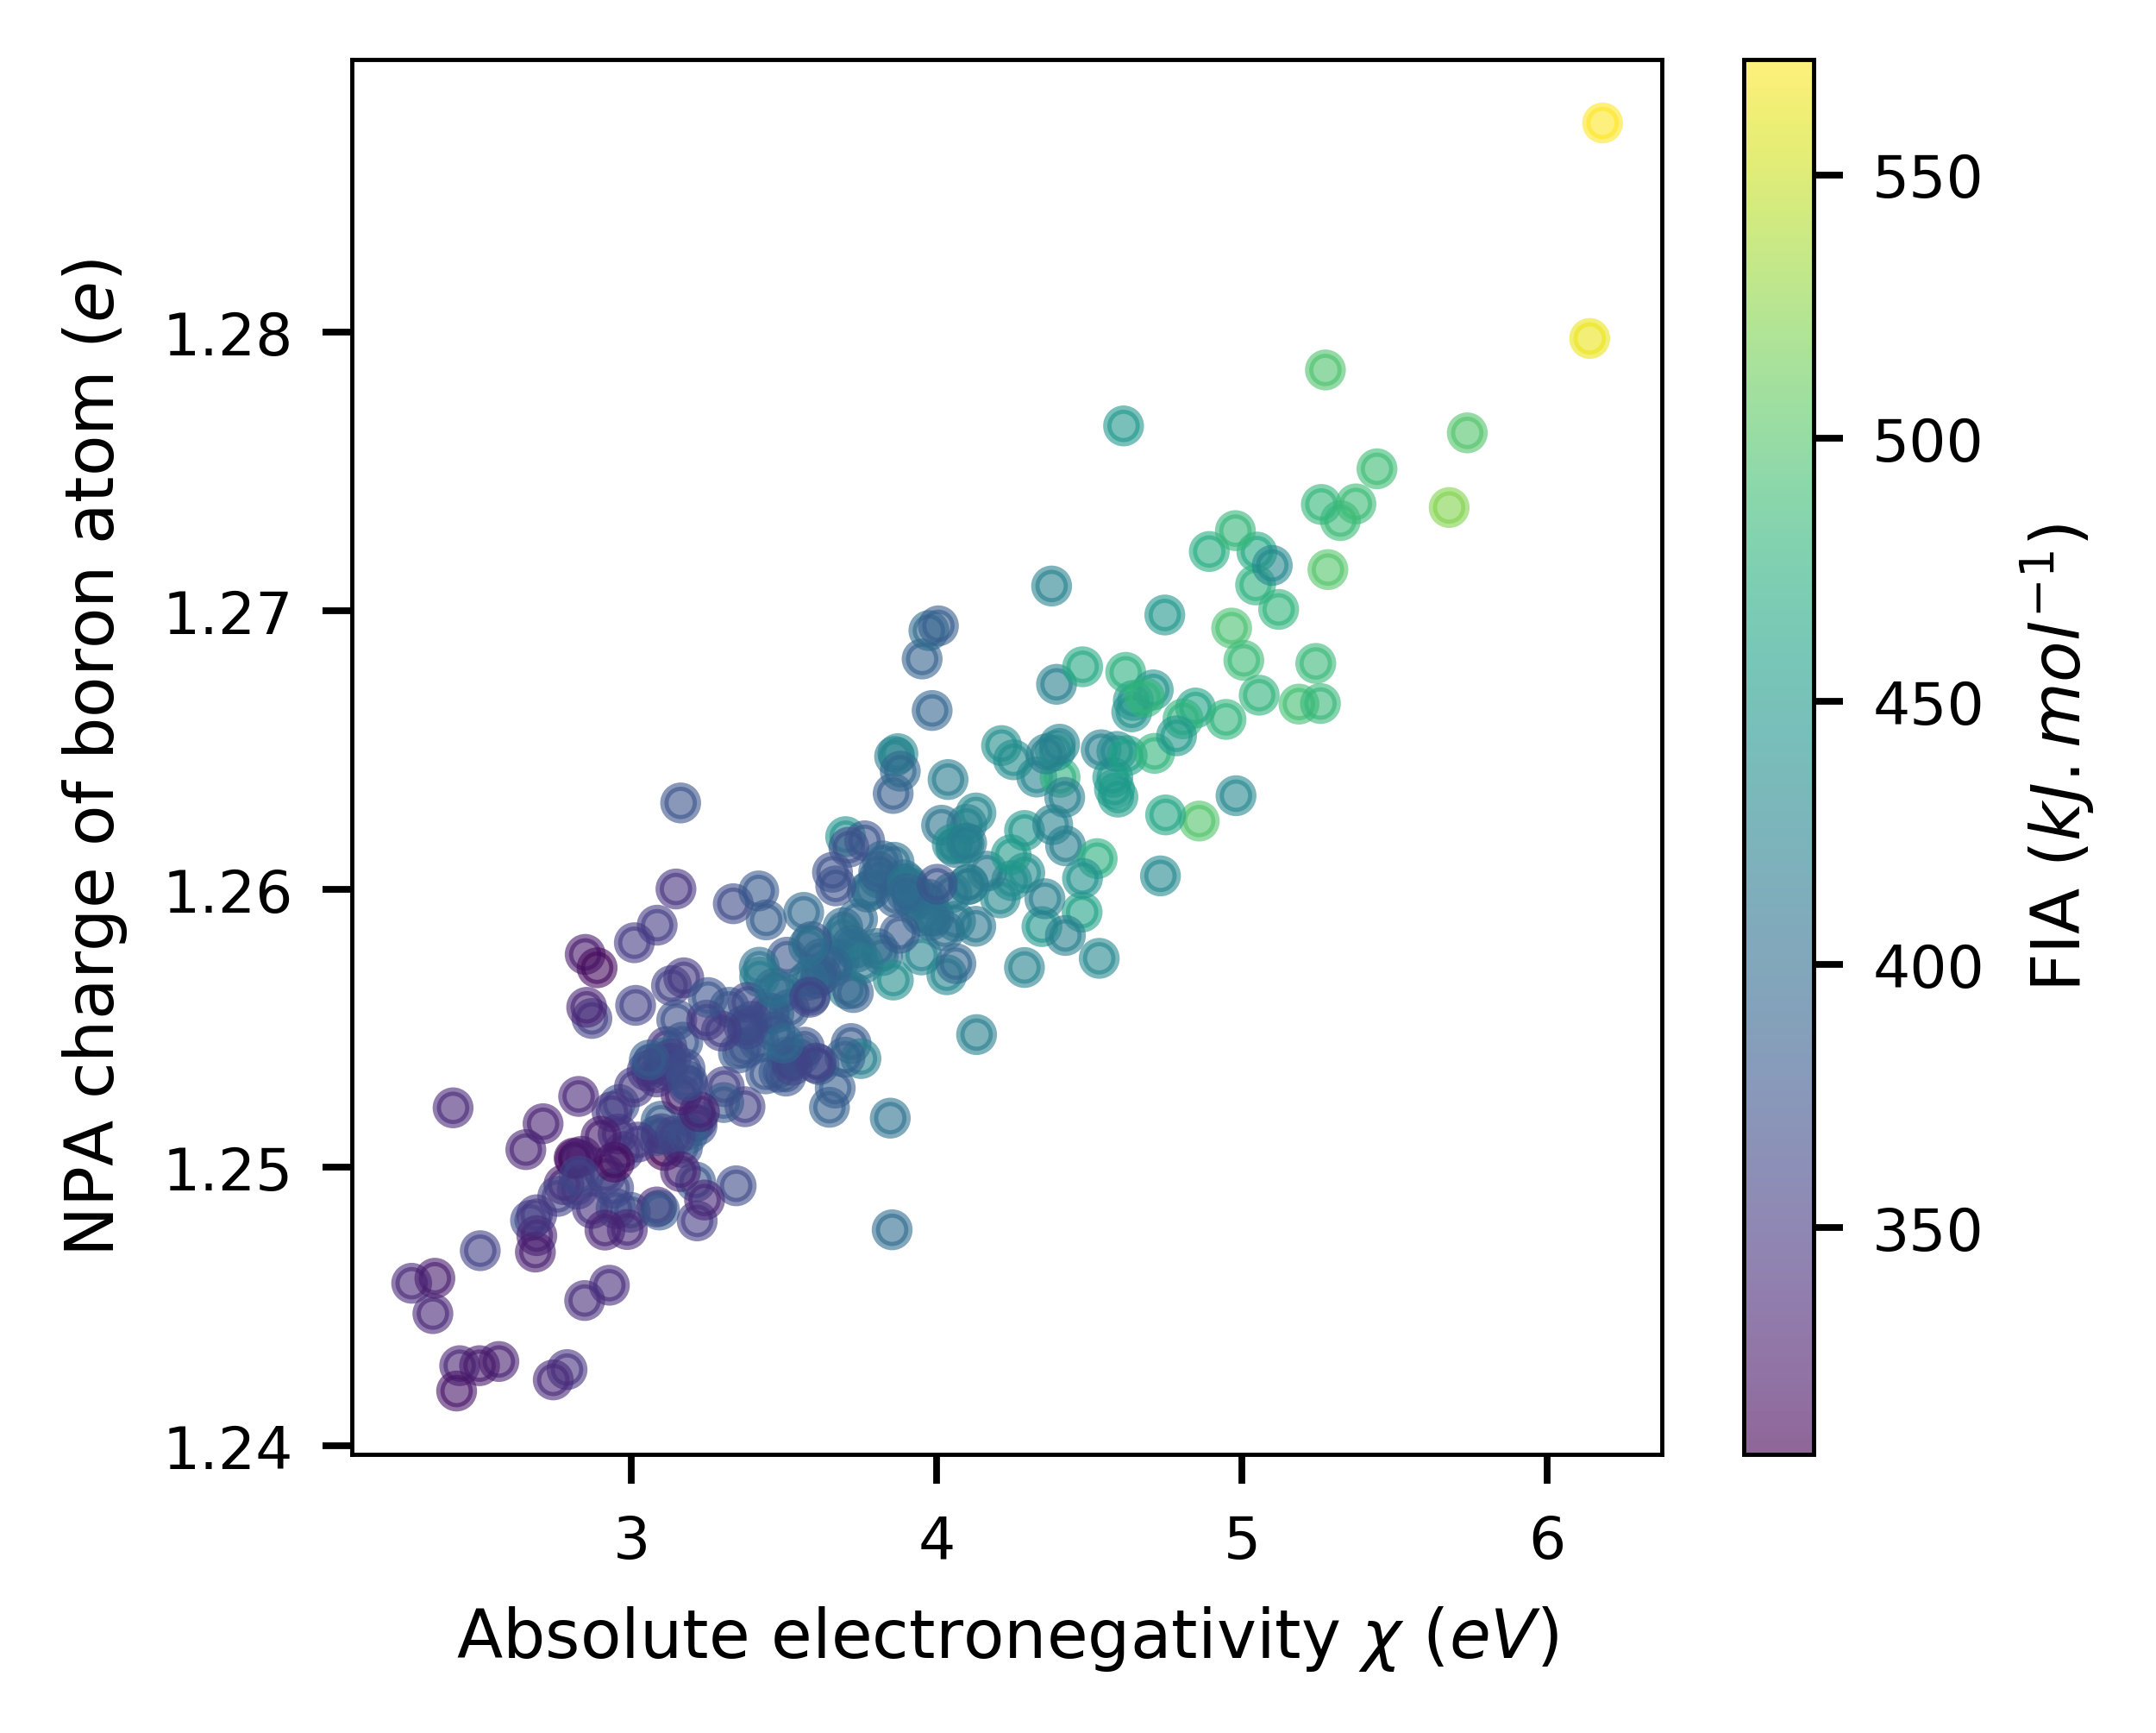

In [46]:
fig, ax = plt.subplots(figsize=(3.5, 3))

electronegativity = df_X_ONO['electronegativity']*27.2107
charge = df_X_ONO['NPA_charge']

sc = ax.scatter(electronegativity, charge , s = 15, alpha = 0.6, c = df_X_ONO['FIA'])

cbar = fig.colorbar(sc,ax=ax, alpha = 0.6)
cbar.set_label("FIA ($kJ.mol^{-1}$)")

ax.set_ylabel('NPA charge of boron atom ($e$)')
ax.set_xlabel('Absolute electronegativity $\chi$ ($eV$)')

#ax.text(0.05, 0.95, 'FIA = 60.0 $\cdot \chi$ + 8.15 $\cdot$ NPA charge + 161 \n R²=0.88', transform=ax.transAxes,verticalalignment='top')

fig.savefig(f'../results/interpretability/quantum_descriptors/FIA_electronegativity_charge_plot.png', facecolor = 'white', format = 'png', transparent = False, bbox_inches='tight')

In [28]:
df = pd.DataFrame()
df['electronegativity']=electronegativity
df['charge']=charge

In [29]:
model = LinearRegression()

model.fit(df, df_X_ONO.FIA)

LinearRegression()

In [30]:
model.coef_

array([60.05291232,  8.15295414])

In [32]:
model.intercept_

161.4548393641934

In [35]:
model.score(df, df_X_ONO.FIA)

0.8835193832013962

In [26]:
electronegativity

0      4.098340
1      3.719431
2      3.614397
3      3.891130
4      3.680927
         ...   
267    3.583649
268    3.222699
269    2.846783
270    3.182836
271    3.239570
Name: electronegativity, Length: 272, dtype: float64

In [27]:
charge

0      1.26232
1      1.25445
2      1.25369
3      1.26033
4      1.25745
        ...   
267    1.25611
268    1.25200
269    1.24522
270    1.25311
271    1.24883
Name: NPA_charge, Length: 272, dtype: float64

In [25]:
np.array(electronegativity, charge)

array([4.09833958, 3.71943058, 3.61439728, 3.8911301 , 3.68092744,
       5.05602017, 3.44133723, 3.58691447, 3.21494421, 3.95208207,
       3.16120307, 4.0622854 , 4.32745367, 3.44868412, 3.77289961,
       2.66950572, 3.73793386, 2.99671439, 4.25139977, 3.84772903,
       3.50936398, 4.0330339 , 3.37194994, 3.21535237, 3.09807425,
       3.08433284, 3.13113525, 4.34446036, 3.70147152, 4.40391574,
       4.10418988, 3.69235594, 3.61943126, 2.34978   , 3.70732182,
       3.11562515, 2.84855213, 2.6900498 , 4.06146908, 4.20786265,
       4.4760241 , 2.87181728, 3.4829696 , 3.33358286, 2.88759948,
       4.64377806, 3.46637107, 3.74051888, 3.60541775, 4.28827027,
       3.43997669, 3.16718943, 3.10827826, 2.78909675, 2.81549113,
       2.43753451, 3.69290015, 3.14841404, 2.50488099, 2.9153544 ,
       3.72092717, 3.1681418 , 3.41779997, 4.59330221, 3.95031337,
       2.96025205, 3.08283626, 3.75167526, 3.21426394, 3.35045349,
       3.18474033, 3.21018233, 3.99004099, 3.00977553, 3.10610